In [2]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Data pre-processing

In [148]:
#get wd
os.getcwd()

'/Users/rachelkoh/Desktop/BC2407-Energy-Forecasting/notebooks'

In [149]:
data_dir = os.getcwd

In [15]:
prosumer = pd.read_csv('../data/raw/train.csv')
# Get net demand
prosumer['datetime'] = pd.to_datetime(prosumer['datetime'])
# prosumer['net_demand'] = prosumer[prosumer['is_consumption'] == 1].reset_index()['target'] - prosumer[prosumer['is_consumption'] == 0].reset_index()['target']
# net_prosumer = prosumer.drop(columns=['target', 'is_consumption','county','is_business','product_type','data_block_id','row_id','prediction_unit_id']).groupby('datetime').sum()
# Date selected due to corrupted data after
# net_prosumer = net_prosumer[net_prosumer.index < "2022-07-21 10:00:00"]
net_prosumer = prosumer[prosumer['is_consumption'] == 1].drop(columns='is_consumption')[['target', 'datetime']].groupby('datetime').sum() - prosumer[prosumer['is_consumption'] == 0].drop(columns='is_consumption')[['target', 'datetime']].groupby('datetime').sum()
net_prosumer['demand'] = prosumer[prosumer['is_consumption'] == 1].drop(columns='is_consumption')[['target', 'datetime']].groupby('datetime').sum()
net_prosumer['supply'] = prosumer[prosumer['is_consumption'] == 0].drop(columns='is_consumption')[['target', 'datetime']].groupby('datetime').sum()
net_prosumer.describe()

target        demand        supply
count  15312.000000  15312.000000  15312.000000
mean   24491.749526  30356.185163   5864.435638
std    19095.117622   9943.956810  12483.735708
min   -81630.133000      0.000000      0.000000
25%    20476.536000  23726.007750     42.913750
50%    27624.398500  28921.808500    109.283500
75%    35263.906250  36038.074750   3888.608750
max    63251.063000  63354.178000  89930.586000

In [19]:
weather_history = pd.read_csv('../data/raw/historical_weather.csv')
weather_history['datetime'] = pd.to_datetime(weather_history['datetime'])
weather_history = weather_history.drop(columns=['latitude', 'longitude', 'data_block_id']).groupby("datetime").mean()
weather_history.describe()

temperature      dewpoint          rain      snowfall  \
count  15275.000000  15275.000000  15275.000000  15275.000000   
mean       5.740960      2.240304      0.049620      0.016049   
std        7.635356      6.846250      0.118073      0.051131   
min      -14.283929    -17.221429      0.000000      0.000000   
25%       -0.054464     -2.624554      0.000000      0.000000   
50%        5.192857      1.574107      0.004464      0.000000   
75%       10.893304      6.821429      0.038393      0.003750   
max       27.278571     19.208929      1.495536      0.898750   

       surface_pressure  cloudcover_total  cloudcover_low  cloudcover_mid  \
count      15275.000000      15275.000000    15275.000000    15275.000000   
mean        1009.281510         60.912753       46.685981       34.407020   
std           11.964149         31.213803       33.703470       29.682011   
min          960.000000          0.000000        0.000000        0.000000   
25%         1002.493750         33.589286       13.169643        7.000000   
50%         1010.561607         67.428571       45.669643       27.553571   
75%         1017.041071         89.924107       79.053571       57.125000   
max         1043.284821        100.000000      100.000000       99.964286   

       cloudcover_high  windspeed_10m  winddirection_10m  shortwave_radiation  \
count     15275.000000   15275.000000       15275.000000         15275.000000   
mean         36.051410       4.849868         197.869471           106.490520   
std          32.114876       1.849202          72.283113           171.397301   
min           0.000000       1.091766          15.598214             0.000000   
25%           5.348214       3.397321         150.517857             0.901786   
50%          28.553571       4.662202         205.928571            10.625000   
75%          61.901786       6.162946         248.776786           146.035714   
max         100.000000      12.023313         356.303571           780.973214   

       direct_solar_radiation  diffuse_radiation  
count            15275.000000       15275.000000  
mean                64.452931          42.037589  
std                122.710267          58.382343  
min                  0.000000           0.000000  
25%                  0.071429           0.678571  
50%                  5.080357           3.830357  
75%                 59.808036          75.491071  
max                670.464286         286.678571

In [20]:
weather_forecast = pd.read_csv('../data/raw/weather_forecast.csv')
weather_forecast['origin_datetime'] = pd.to_datetime(weather_forecast['origin_datetime'])
weather_forecast['forecast_datetime'] = weather_forecast['origin_datetime'] + pd.to_timedelta(weather_forecast['hours_ahead'], unit='h')
weather_forecast = weather_forecast.drop(columns=['latitude', 'longitude','origin_datetime','hours_ahead','data_block_id']).groupby("forecast_datetime").mean()
weather_forecast.columns = ['24h_forecasted_{}'.format(measurement) for measurement in weather_forecast.columns]
weather_forecast.index = weather_forecast.index.rename('datetime')
weather_forecast = weather_forecast.shift(-1, freq=pd.DateOffset(days=1)).iloc[24:]
weather_forecast.describe()

24h_forecasted_temperature  24h_forecasted_dewpoint  \
count                15288.000000             15288.000000   
mean                     5.742472                 2.409083   
std                      7.538374                 6.863402   
min                    -14.440721               -16.940665   
25%                     -0.048984                -2.465230   
50%                      5.090133                 1.768217   
75%                     10.841335                 6.974909   
max                     26.833043                18.842153   

       24h_forecasted_cloudcover_high  24h_forecasted_cloudcover_low  \
count                    15288.000000                   15288.000000   
mean                         0.394735                       0.434548   
std                          0.329759                       0.349925   
min                          0.000000                       0.000000   
25%                          0.082352                       0.088770   
50%                          0.334667                       0.370242   
75%                          0.670092                       0.776013   
max                          1.000000                       1.000002   

       24h_forecasted_cloudcover_mid  24h_forecasted_cloudcover_total  \
count                   15288.000000                     15288.000000   
mean                        0.359073                         0.681955   
std                         0.312691                         0.304233   
min                         0.000000                         0.000000   
25%                         0.076461                         0.447603   
50%                         0.280654                         0.773052   
75%                         0.601561                         0.967200   
max                         1.000000                         1.000004   

       24h_forecasted_10_metre_u_wind_component  \
count                              15288.000000   
mean                                   1.256946   
std                                    3.509397   
min                                   -8.658795   
25%                                   -1.320996   
50%                                    1.603814   
75%                                    3.826776   
max                                   11.936635   

       24h_forecasted_10_metre_v_wind_component  \
count                              15288.000000   
mean                                   0.729893   
std                                    3.687055   
min                                  -12.247292   
25%                                   -1.814660   
50%                                    0.849566   
75%                                    3.420202   
max                                   11.132244   

       24h_forecasted_direct_solar_radiation  \
count                           15288.000000   
mean                              151.321558   
std                               233.169500   
min                                -0.034623   
25%                                 0.000000   
50%                                 1.115684   
75%                               254.745349   
max                               884.038571   

       24h_forecasted_surface_solar_radiation_downwards  \
count                                      15288.000000   
mean                                         110.867103   
std                                          182.173539   
min                                           -0.018016   
25%                                            0.000000   
50%                                            1.155606   
75%                                          154.321860   
max                                          798.967460   

       24h_forecasted_snowfall  24h_forecasted_total_precipitation  
count             1.528800e+04                        15288.000000  
mean              2.535214e-05                            0.000079  
std               7.544838e-05                   

In [21]:
gas_prices =pd.read_csv('../data/raw/gas_prices.csv')
# available before forecast date
gas_prices['forecast_date'] = pd.to_datetime(gas_prices['forecast_date'])
gas_prices = gas_prices.drop(columns = ['data_block_id', 'origin_date']).set_index('forecast_date')
gas_prices = gas_prices.resample('H').ffill()
gas_prices.index = gas_prices.index.rename('datetime')
gas_prices.describe()

lowest_price_per_mwh  highest_price_per_mwh
count          15265.000000           15265.000000
mean              95.136249             107.865758
std               47.483048              54.668638
min               28.100000              34.000000
25%               60.000000              67.530000
50%               85.210000              93.470000
75%              109.000000             130.740000
max              250.000000             305.000000

In [22]:
electricity_prices = pd.read_csv('../data/raw/electricity_prices.csv')
# available before forecast date
electricity_prices['forecast_date'] = pd.to_datetime(electricity_prices['forecast_date'])
electricity_prices = electricity_prices.drop(columns = ['data_block_id', 'origin_date']).set_index('forecast_date')
electricity_prices.index = electricity_prices.index.rename('datetime')
electricity_prices.describe()

euros_per_mwh
count   15286.000000
mean      157.064176
std       121.148625
min       -10.060000
25%        85.290000
50%       128.280000
75%       199.797500
max      4000.000000

In [23]:
client = pd.read_csv('../data/raw/client.csv')
client['date'] = pd.to_datetime(client['date'])
client = pd.get_dummies(client, columns=['product_type'])
client = client.drop(columns=['county','data_block_id']).groupby('date').sum()
client = client.resample('H').ffill()
client.index = client.index.rename('datetime')
client.describe()

eic_count  installed_capacity   is_business  product_type_0  \
count  15241.000000        15241.000000  15241.000000    15241.000000   
mean    4830.246375        95541.519130     35.377994        5.566958   
std     1231.323551        19717.032753      1.866956        0.793590   
min     3156.000000        70651.260000     31.000000        4.000000   
25%     3762.000000        76775.150000     35.000000        6.000000   
50%     4620.000000        93411.910000     36.000000        6.000000   
75%     5914.000000       111288.760000     37.000000        6.000000   
max     7457.000000       148218.705000     38.000000        6.000000   

       product_type_1  product_type_2  product_type_3  
count    15241.000000    15241.000000         15241.0  
mean        25.521291        4.823502            30.0  
std          1.051787        0.869776             0.0  
min         22.000000        2.000000            30.0  
25%         26.000000        4.000000            30.0  
50%         26.000000        5.000000            30.0  
75%         26.000000        5.000000            30.0  
max         26.000000        7.000000            30.0

In [24]:
final_df = net_prosumer.join(client, how='inner').join(weather_history, how='inner').join(gas_prices, how = 'inner').join(electricity_prices, how = 'inner').join(weather_forecast, how='left')

In [25]:
final_df.tail()

target     demand    supply  eic_count  \
datetime                                                         
2023-05-28 20:00:00  20638.683  23967.127  3328.444       7452   
2023-05-28 21:00:00  24731.686  25785.378  1053.692       7452   
2023-05-28 22:00:00  26346.081  26670.789   324.708       7452   
2023-05-28 23:00:00  25988.918  26120.879   131.961       7452   
2023-05-29 00:00:00  24959.784  25056.095    96.311       7457   

                     installed_capacity  is_business  product_type_0  \
datetime                                                               
2023-05-28 20:00:00          148058.705           36               6   
2023-05-28 21:00:00          148058.705           36               6   
2023-05-28 22:00:00          148058.705           36               6   
2023-05-28 23:00:00          148058.705           36               6   
2023-05-29 00:00:00          148218.705           36               6   

                     product_type_1  product_type_2  product_type_3  ...  \
datetime                                                             ...   
2023-05-28 20:00:00              26               3              30  ...   
2023-05-28 21:00:00              26               3              30  ...   
2023-05-28 22:00:00              26               3              30  ...   
2023-05-28 23:00:00              26               3              30  ...   
2023-05-29 00:00:00              26               3              30  ...   

                     24h_forecasted_cloudcover_high  \
datetime                                              
2023-05-28 20:00:00                        0.334314   
2023-05-28 21:00:00                        0.403059   
2023-05-28 22:00:00                        0.520312   
2023-05-28 23:00:00                        0.538961   
2023-05-29 00:00:00                        0.507522   

                     24h_forecasted_cloudcover_low  \
datetime                                             
2023-05-28 20:00:00                       0.008760   
2023-05-28 21:00:00                       0.006846   
2023-05-28 22:00:00                       0.002747   
2023-05-28 23:00:00                       0.001612   
2023-05-29 00:00:00                       0.001529   

                     24h_forecasted_cloudcover_mid  \
datetime                                             
2023-05-28 20:00:00                       0.324647   
2023-05-28 21:00:00                       0.348431   
2023-05-28 22:00:00                       0.424235   
2023-05-28 23:00:00                       0.541801   
2023-05-29 00:00:00                       0.644752   

                     24h_forecasted_cloudcover_total  \
datetime                                               
2023-05-28 20:00:00                         0.472483   
2023-05-28 21:00:00                         0.549039   
2023-05-28 22:00:00                         0.661612   
2023-05-28 23:00:00                         0.711949   
2023-05-29 00:00:00                         0.748189   

                     24h_forecasted_10_metre_u_wind_component  \
datetime                                                        
2023-05-28 20:00:00                                  2.508707   
2023-05-28 21:00:00                                  2.269524   
2023-05-28 22:00:00                                  2.185002   
2023-05-28 23:00:00                                  2.184423   
2023-05-29 00:00:00                                  2.245457   

                     24h_forecasted_10_metre_v_wind_component  \
datetime                                                        
2023-05-28 20:00:00                                 -1.642133   
2023-05-28 21:00:00                                 -1.335344   
2023-05-28 22:00:00                                 -1.022191   
2023-05-28 23:00:00                                 -0.670376   
2023-05-29 00:00:00                                 -0.373383   

                     24h_forecasted_direct_solar_radiation  \
datetime    

In [26]:
# null or 0 values in training data
final_df[final_df['target']==0].head()
# for these rows, copy the values from previous timestamp
zero_target_rows = final_df['target'] == 0

previous_values = final_df.shift(1)

final_df.loc[zero_target_rows, ['target', 'demand', 'supply']] = previous_values.loc[zero_target_rows, ['target', 'demand', 'supply']]

In [27]:
final_df = final_df[3:]
final_df['diff_demand'] = final_df['demand'].diff()
final_df['diff_supply'] = final_df['supply'].diff()

In [28]:
final_df.to_parquet('../data/processed/ENEFIT_dataset.parquet')

# EDA Time analysis

In [3]:
final_df = pd.read_parquet('../data/processed/ENEFIT_dataset.parquet')

In [4]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15232 entries, 2021-09-01 07:00:00 to 2023-05-29 00:00:00
Data columns (total 47 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   target                                            15232 non-null  float64
 1   demand                                            15232 non-null  float64
 2   supply                                            15232 non-null  float64
 3   eic_count                                         15232 non-null  int64  
 4   installed_capacity                                15232 non-null  float64
 5   is_business                                       15232 non-null  int64  
 6   product_type_0                                    15232 non-null  int64  
 7   product_type_1                                    15232 non-null  int64  
 8   product_type_2                                    15232 non-n

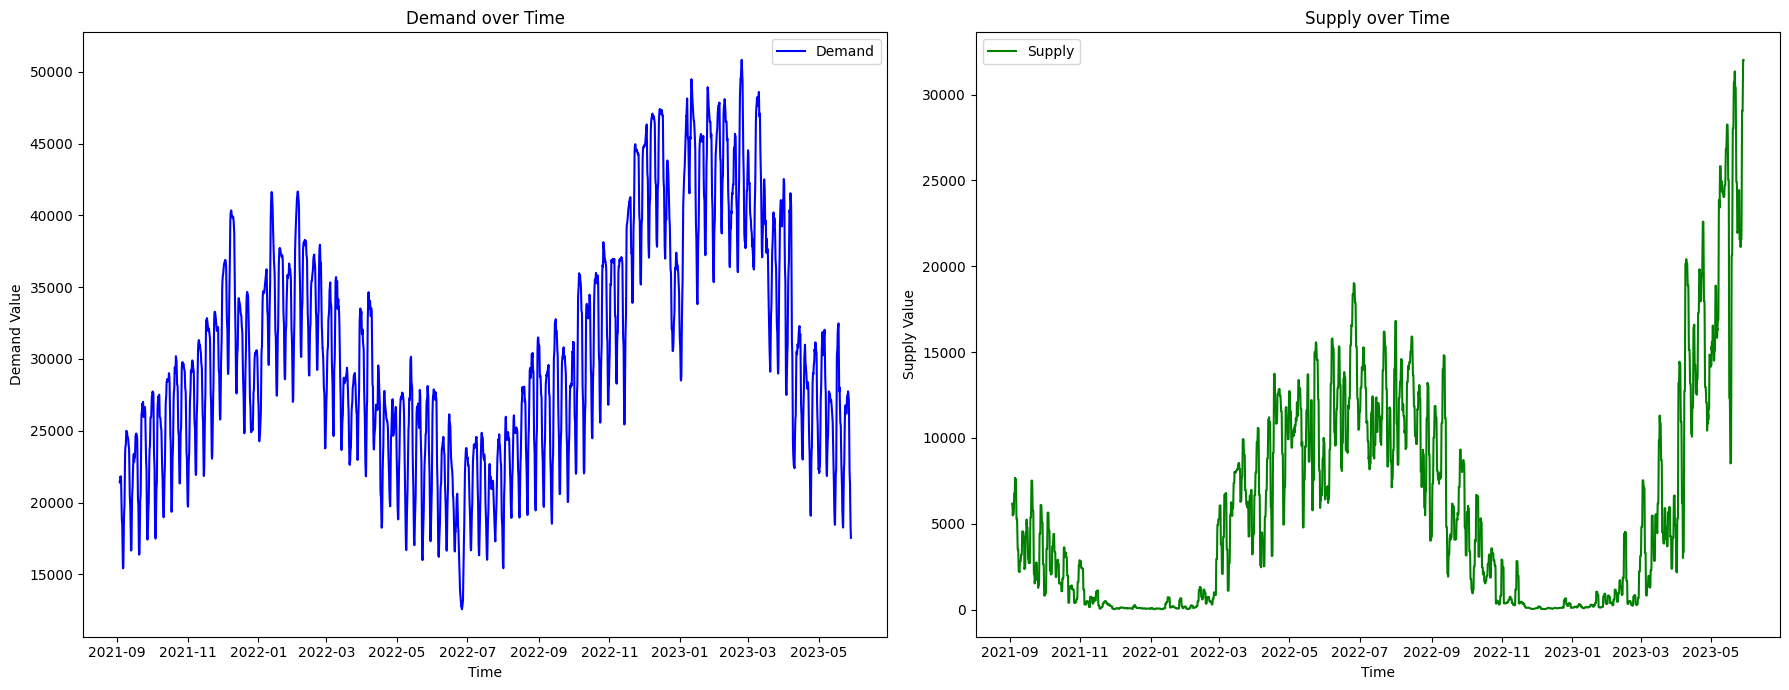

In [17]:

# PLotting target variable over time
series_demand = final_df['demand']
series_supply = final_df['supply']
series_target = final_df['target']
fig, axs = plt.subplots(1, 2, figsize=(18, 7))  

series_demand = series_demand.rolling(window=48).mean()
series_supply = series_supply.rolling(window=48).mean()
 
axs[0].plot(series_demand.index, series_demand, label='Demand', linewidth=1.5, color='blue')
axs[0].set_title('Demand over Time')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Demand Value')
axs[0].legend()

axs[1].plot(series_supply.index, series_supply, label='Supply', linewidth=1.5, color='green')
axs[1].set_title('Supply over Time')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Supply Value')
axs[1].legend()

plt.tight_layout()

plt.show()

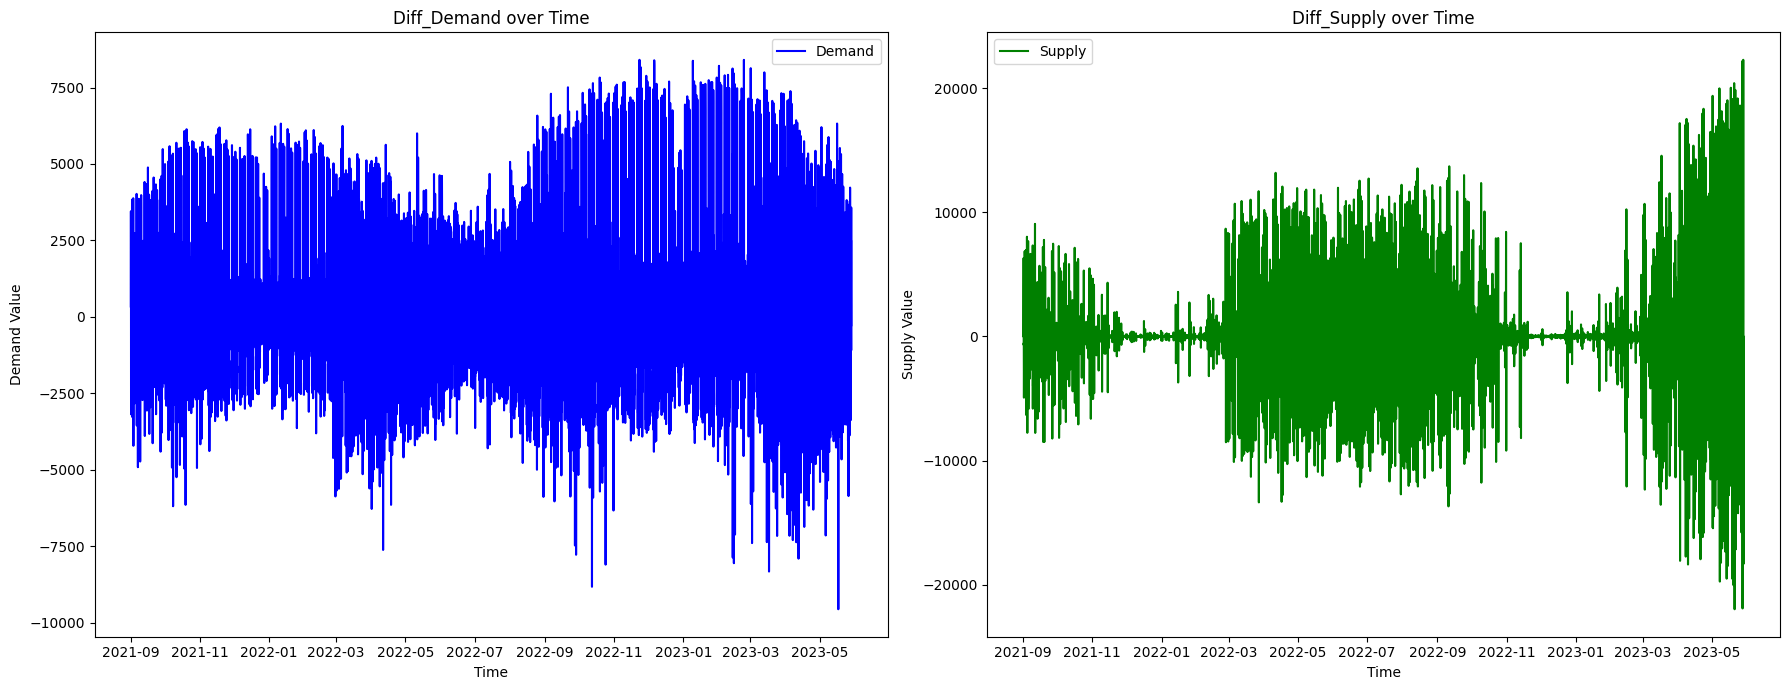

In [18]:
#drop 0s
final_df = final_df[final_df['demand'] != 0]
final_df = final_df[final_df['supply'] != 0]
# PLotting diff_target variable over time
series_demand = final_df['diff_demand']
series_supply = final_df['diff_supply']
fig, axs = plt.subplots(1, 2, figsize=(18, 7))  

 
axs[0].plot(series_demand.index, series_demand, label='Demand', linewidth=1.5, color='blue')
axs[0].set_title('Diff_Demand over Time')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Demand Value')
axs[0].legend()

axs[1].plot(series_supply.index, series_supply, label='Supply', linewidth=1.5, color='green')
axs[1].set_title('Diff_Supply over Time')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Supply Value')
axs[1].legend()

plt.tight_layout()

plt.show()

In [155]:
# print rows with large outliers in diff_demand
print(final_df[final_df['diff_demand'] > 15000].head())

print(final_df[final_df['diff_demand'] < -15000].head())


                        target     demand  supply  eic_count  \
datetime                                                       
2021-10-31 04:00:00  18777.155  18791.204  14.049       3329   
2022-03-27 04:00:00  24805.950  24877.441  71.491       3917   
2022-10-30 04:00:00  23557.597  23616.097  58.500       5435   
2023-03-26 04:00:00  27302.443  27379.927  77.484       6419   

                     installed_capacity  is_business  product_type_0  \
datetime                                                               
2021-10-31 04:00:00           74031.460           32               4   
2022-03-27 04:00:00           79070.310           37               6   
2022-10-30 04:00:00          105136.310           37               6   
2023-03-26 04:00:00          119424.205           35               6   

                     product_type_1  product_type_2  product_type_3  ...  \
datetime                                                             ...   
2021-10-31 04:00:00           

monthly seasonality - peaks and troughs in some months more evident than others

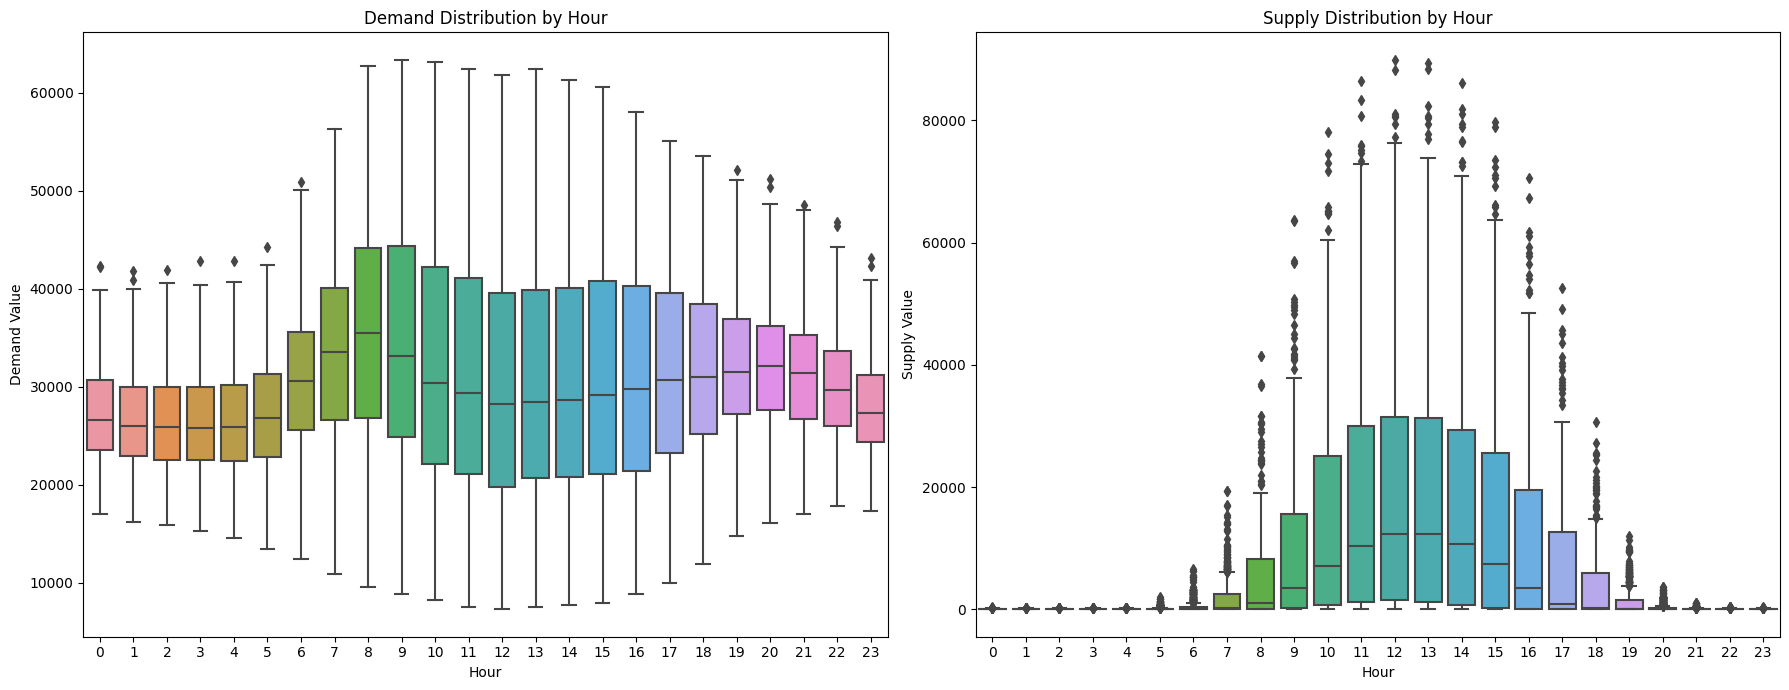

In [19]:
# change to load distribution in demand and supply - plot boxplots for each hour of the day
final_df['hour'] = final_df.index.hour
final_df['day'] = final_df.index.day_name()
final_df['month'] = final_df.index.month_name()
final_df['year'] = final_df.index.year

fig, axs = plt.subplots(1, 2, figsize=(18, 7))
sns.boxplot(x='hour', y='demand', data=final_df, ax=axs[0])
axs[0].set_title('Demand Distribution by Hour')
axs[0].set_xlabel('Hour')
axs[0].set_ylabel('Demand Value')

sns.boxplot(x='hour', y='supply', data=final_df, ax=axs[1])
axs[1].set_title('Supply Distribution by Hour')
axs[1].set_xlabel('Hour')
axs[1].set_ylabel('Supply Value')

plt.tight_layout()
plt.show()

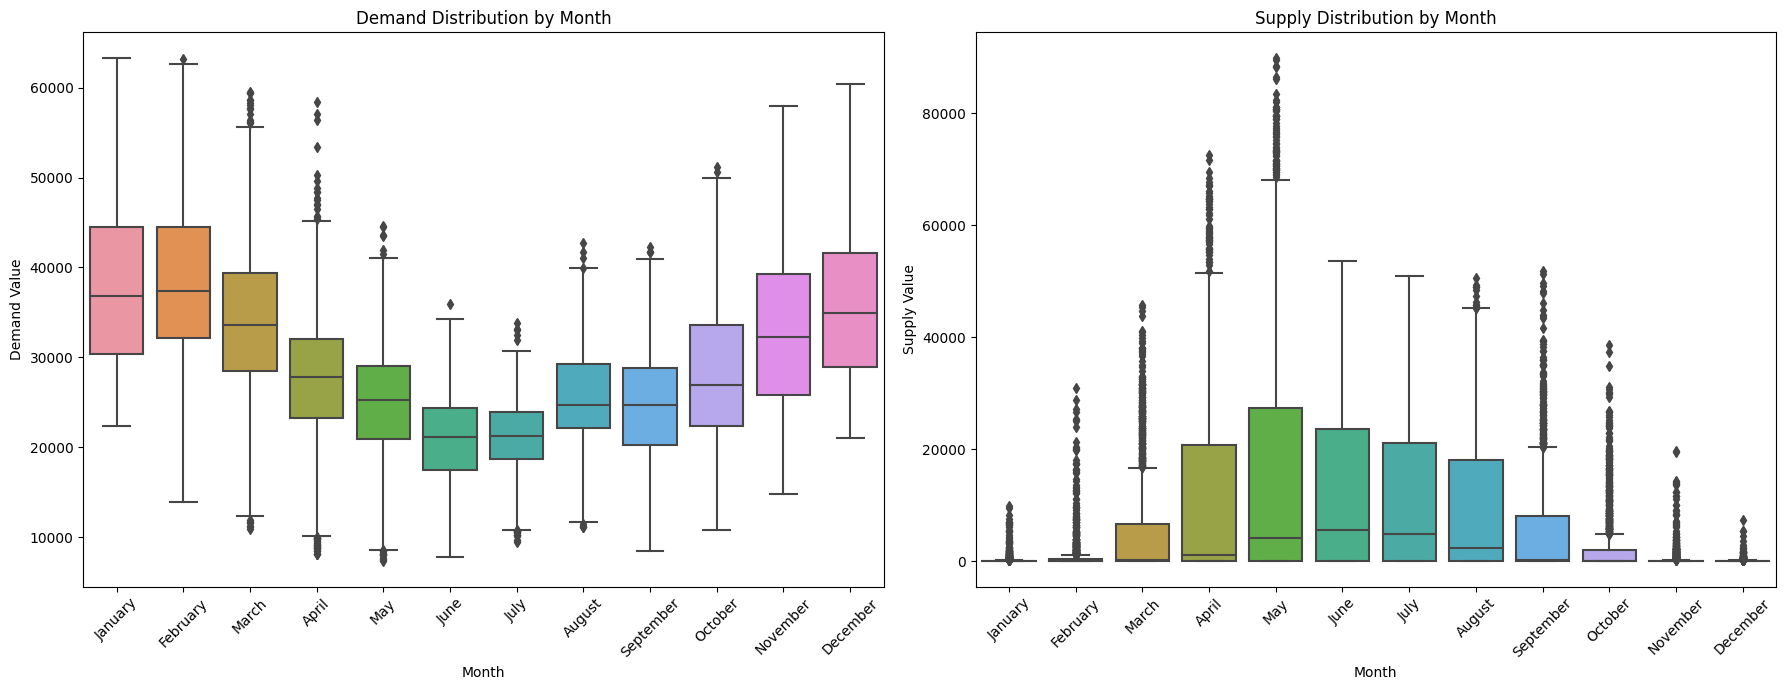

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(18, 7))
order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

sns.boxplot(x='month', y='demand', data=final_df, ax=axs[0],order = order)
axs[0].set_title('Demand Distribution by Month')
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Demand Value')
axs[0].tick_params(axis='x', rotation=45)  # Rotate x ticks by 45 degrees
plt.xticks(rotation=45)

sns.boxplot(x='month', y='supply', data=final_df, ax=axs[1],order = order)
axs[1].set_title('Supply Distribution by Month')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Supply Value')
axs[1].tick_params(axis='x', rotation=45)  # Rotate x ticks by 45 degrees
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

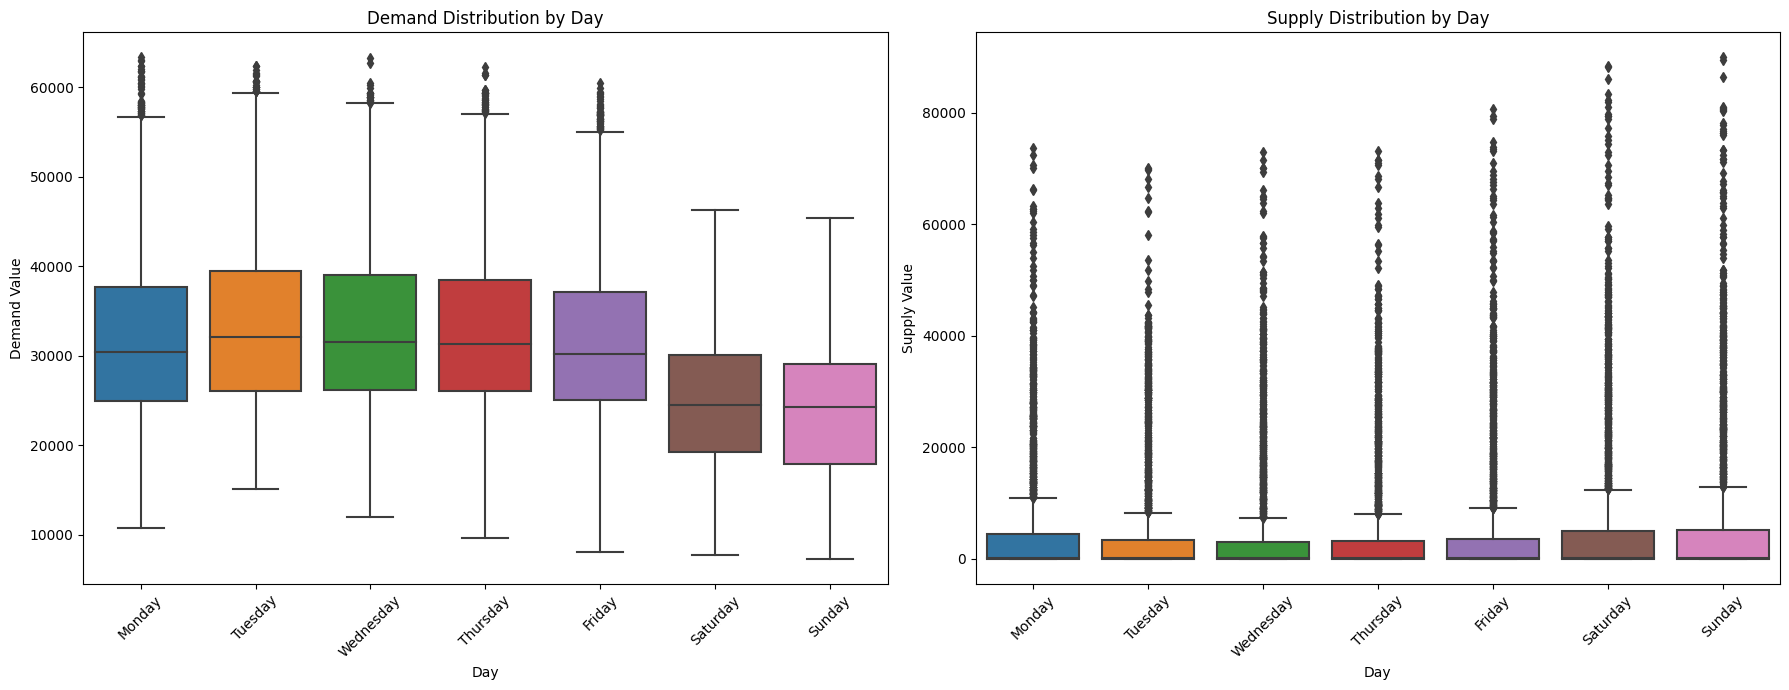

In [21]:
# load distibution in demand and supply - plot boxplots for each day of the week
fig, axs = plt.subplots(1, 2, figsize=(18, 7))

# Define the order of the days of the week
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

sns.boxplot(x='day', y='demand', data=final_df, ax=axs[0], order=order)
axs[0].set_title('Demand Distribution by Day')
axs[0].set_xlabel('Day')
axs[0].set_ylabel('Demand Value')
axs[0].tick_params(axis='x', rotation=45)  # Rotate x ticks by 45 degrees

sns.boxplot(x='day', y='supply', data=final_df, ax=axs[1], order=order)
axs[1].set_title('Supply Distribution by Day')
axs[1].set_xlabel('Day')
axs[1].set_ylabel('Supply Value')
axs[1].tick_params(axis='x', rotation=45)  # Rotate x ticks by 45 degrees

plt.tight_layout()
plt.show()


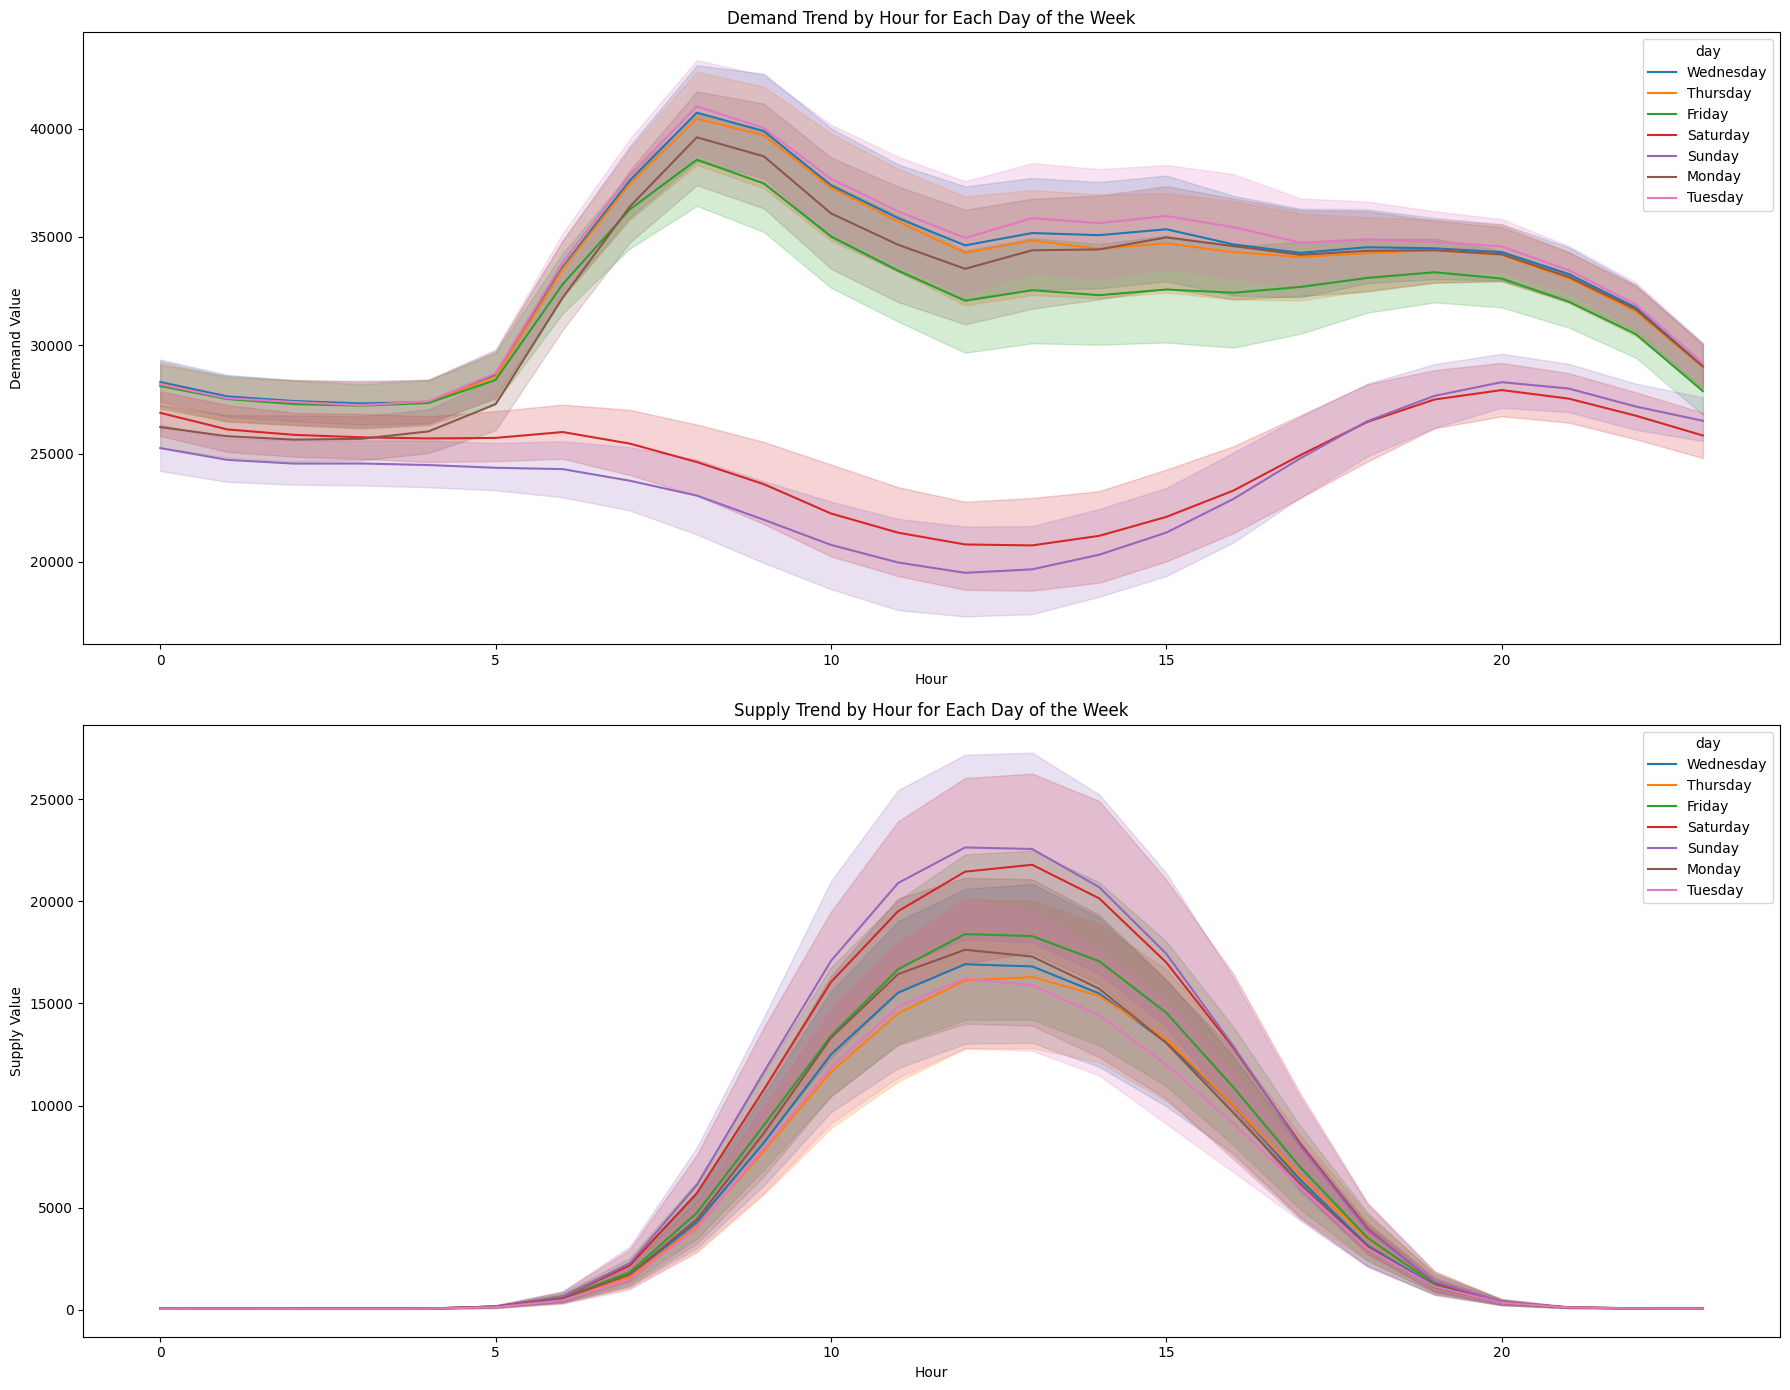

In [22]:

# lineplot of demand trends for each day of the week
fig, axs = plt.subplots(2, 1, figsize=(18, 14))

# plot demand trends
sns.lineplot(x='hour', y='demand', data=final_df, hue='day', ax=axs[0])
axs[0].set_title('Demand Trend by Hour for Each Day of the Week')
axs[0].set_xlabel('Hour')
axs[0].set_ylabel('Demand Value')

# plot supply trends
sns.lineplot(x='hour', y='supply', data=final_df, hue='day', ax=axs[1])
axs[1].set_title('Supply Trend by Hour for Each Day of the Week')
axs[1].set_xlabel('Hour')
axs[1].set_ylabel('Supply Value')

plt.tight_layout()
plt.show()


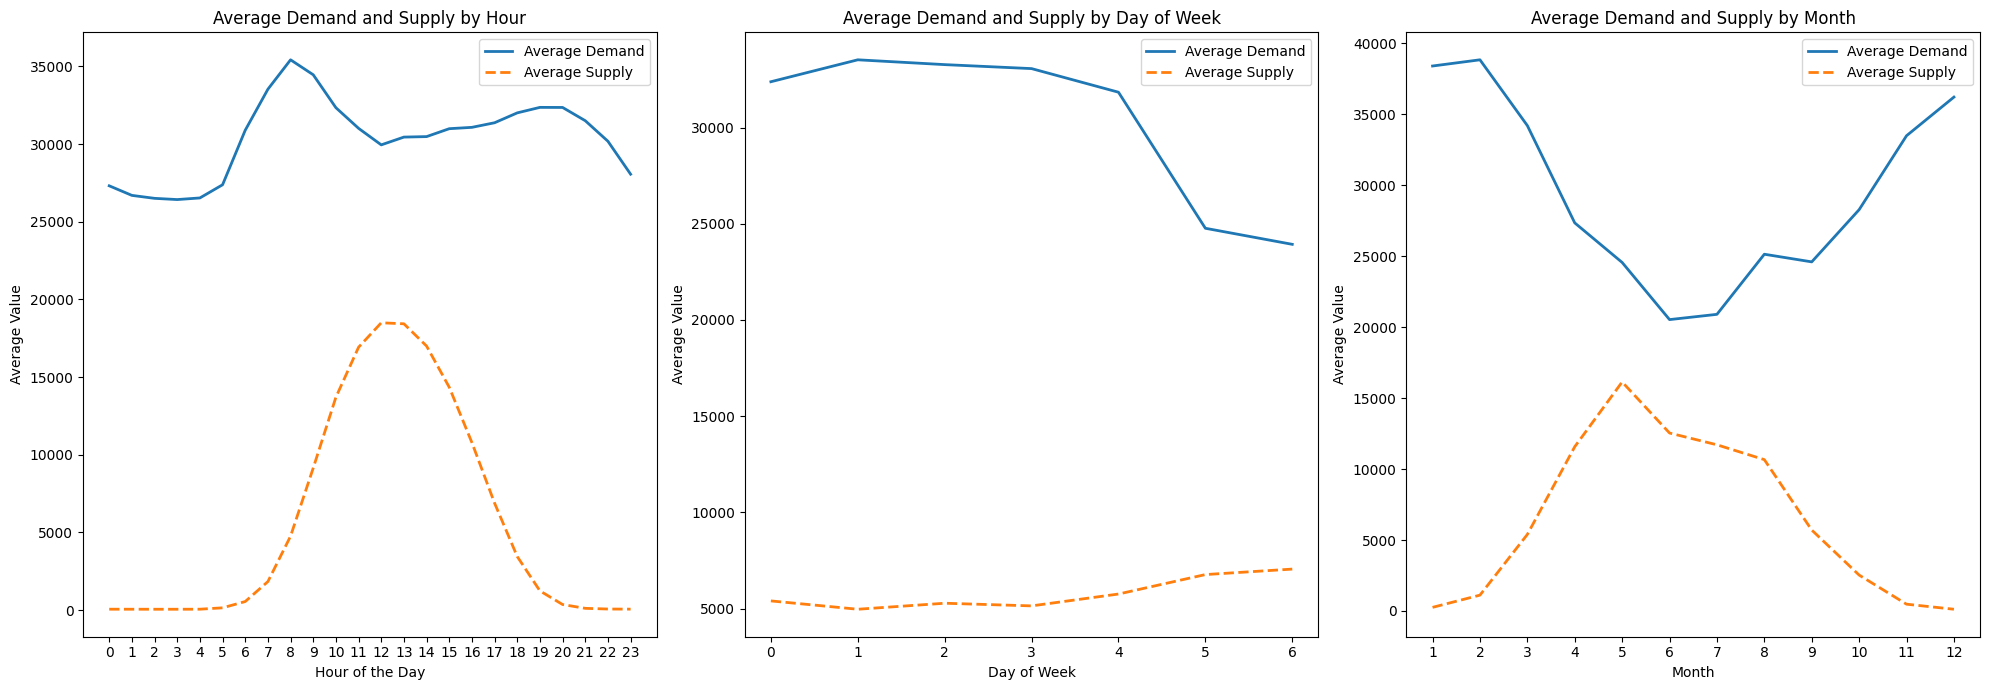

In [23]:
series_demand_hour = final_df['demand'].groupby(final_df.index.hour).mean()
series_supply_hour = final_df['supply'].groupby(final_df.index.hour).mean()

series_demand_dow = final_df['demand'].groupby(final_df.index.dayofweek).mean()
series_supply_dow = final_df['supply'].groupby(final_df.index.dayofweek).mean()

series_demand_month = final_df['demand'].groupby(final_df.index.month).mean()
series_supply_month = final_df['supply'].groupby(final_df.index.month).mean()


plt.figure(figsize=(20, 7))

# by hour
plt.subplot(1, 3, 1)
plt.plot(series_demand_hour.index, series_demand_hour, label='Average Demand', linewidth=2)
plt.plot(series_supply_hour.index, series_supply_hour, label='Average Supply', linewidth=2, linestyle='--')
plt.title('Average Demand and Supply by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Value')
plt.xticks(range(0, 24))
plt.legend()

#  by day of the week
plt.subplot(1, 3, 2)
plt.plot(series_demand_dow.index, series_demand_dow, label='Average Demand', linewidth=2)
plt.plot(series_supply_dow.index, series_supply_dow, label='Average Supply', linewidth=2, linestyle='--')
plt.title('Average Demand and Supply by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Value')
plt.xticks(range(0, 7))
plt.legend()

#  by month
plt.subplot(1, 3, 3)
plt.plot(series_demand_month.index, series_demand_month, label='Average Demand', linewidth=2)
plt.plot(series_supply_month.index, series_supply_month, label='Average Supply', linewidth=2, linestyle='--')
plt.title('Average Demand and Supply by Month')
plt.xlabel('Month')
plt.ylabel('Average Value')
plt.xticks(range(1, 13))
plt.legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


* production peaks midday - and near 0 at night. 
* production peaks in summer, demand drops. due to lesser need for heating during winter.
* production is at its highest during weekends, and consumption drops during weekends. 

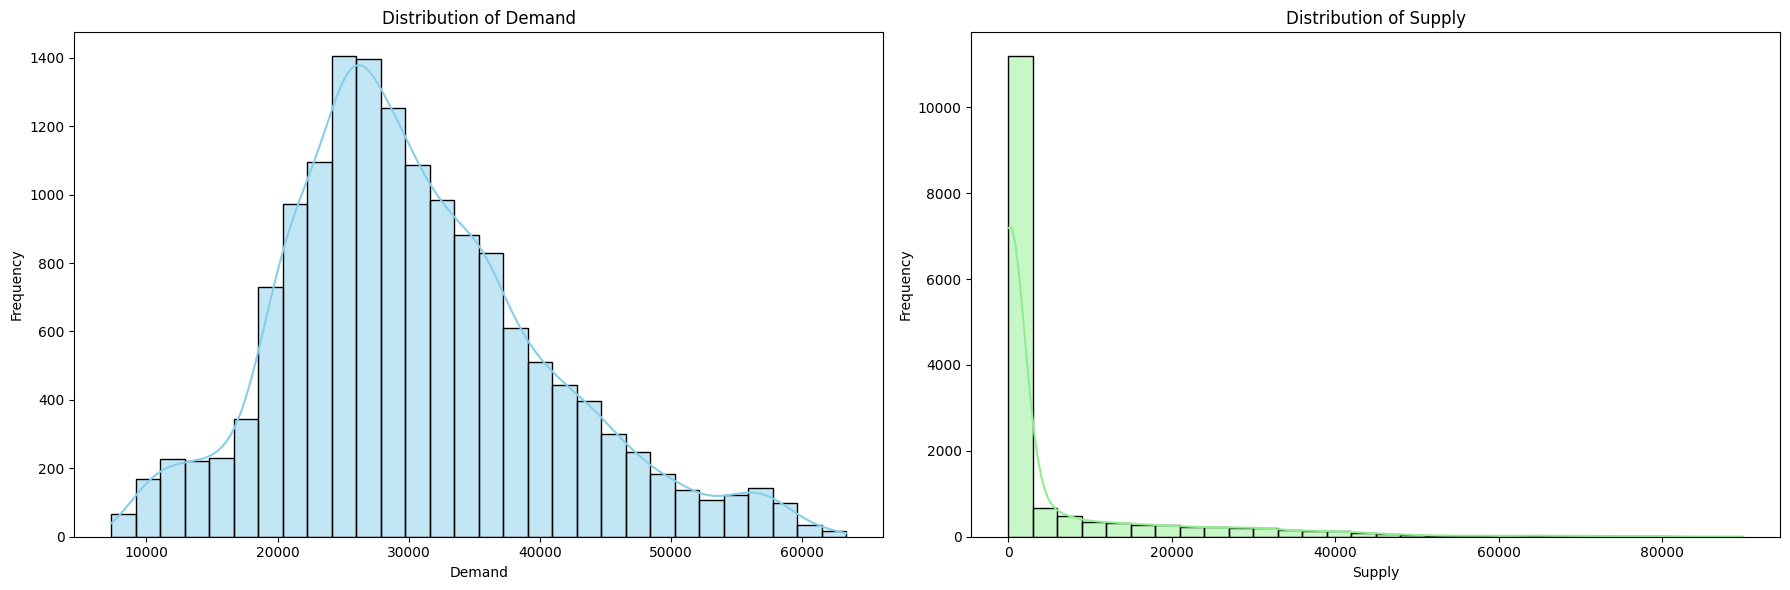

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))

# Plot for Demand
plt.subplot(1, 2, 1)
sns.histplot(final_df['demand'], kde=True, color='skyblue', bins=30)
plt.title('Distribution of Demand')
plt.xlabel('Demand')
plt.ylabel('Frequency')
plt.grid(False)

# Plot for Supply - Improved visualization
plt.subplot(1, 2, 2)
sns.histplot(final_df['supply'], kde=True, color='lightgreen', bins=30)
plt.title('Distribution of Supply')
plt.xlabel('Supply')
plt.ylabel('Frequency')
plt.grid(False)
#plt.xlim(left=final_df['supply'].quantile(0.005), right=final_df['supply'].quantile(0.995))  # Zoom into 1% to 99% quantile range
plt.tight_layout()

# Display the plots
plt.show()


In [25]:
final_df['is_business'].value_counts()

36    6601
37    2855
32    1464
35    1127
38     984
33     744
34     744
31     717
Name: is_business, dtype: int64

### eda on non target variables - temp, wind .. etc over time
* FFT - Utilizing methods like Fast Fourier Transform (FFT) and Singular Spectrum Analysis (SSA), investigate the underlying periodic patterns for an example user. 
* To uncover potential high-frequency patterns within the dataset that may not be immediately apparent, a Fast Fourier Transform (FFT) analysis is conducted on the first ten unique segments of the dataset. This analysis aims to reveal hidden frequency-based characteristics and periodicities within these segments.





In [26]:

periods_in_hours = {
    'Quarterly': (365 / 4) * 24,
    'Monthly': 30 * 24,
    'Weekly': 7 * 24,
    'Daily': 24,
    '12-hour': 12,
    '8-hour': 8,
    '6-hour': 6,
    '4-hour': 4
}
frequencies_for_periods = {k: 1/v for k, v in periods_in_hours.items()}


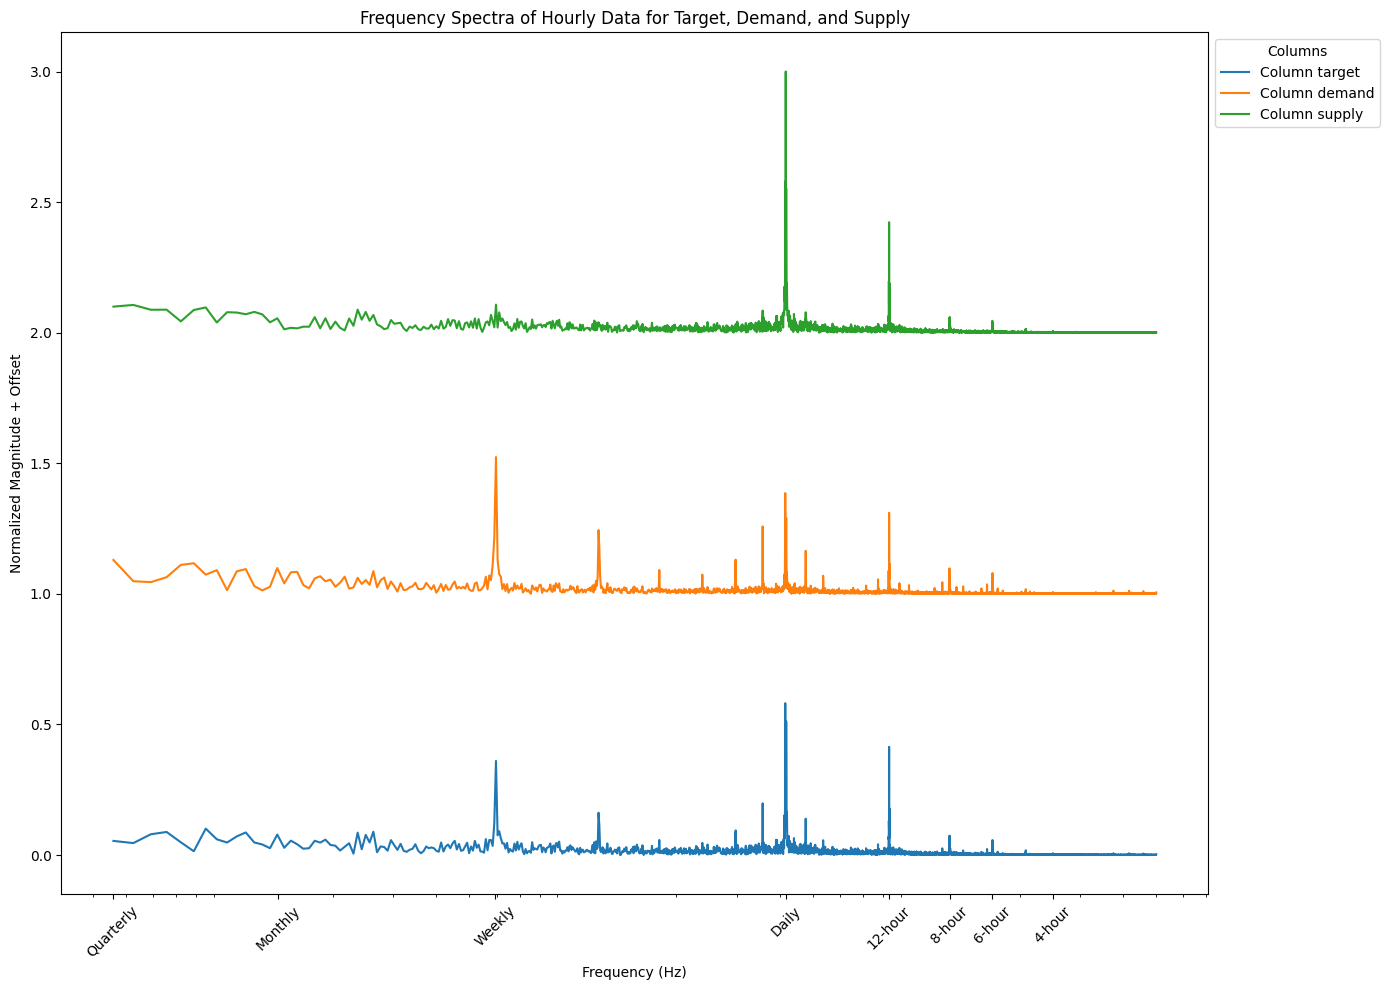

In [27]:
columns_of_interest = ['target', 'demand', 'supply']

plt.figure(figsize=(14, 10))
plt.xscale('log')

for i, column in enumerate(columns_of_interest):
    column_data = final_df[column].dropna()  # Ensure there are no NaN values
    fft_values = np.fft.fft(column_data)
    frequencies = np.fft.fftfreq(len(fft_values), d=1)  # d=1 because data is hourly
    magnitudes = np.abs(fft_values)[frequencies > 0]
    normalized_magnitudes = magnitudes / np.max(magnitudes)
    positive_freqs = frequencies[frequencies > 0]

    # Filter based on the frequencies greater than the 'Quarterly' period
    valid_freqs = positive_freqs[positive_freqs > frequencies_for_periods['Quarterly']]
    valid_magnitudes = normalized_magnitudes[positive_freqs > frequencies_for_periods['Quarterly']]

    offset_magnitudes = valid_magnitudes + i  # Offset for visual clarity

    plt.plot(valid_freqs, offset_magnitudes, label=f'Column {column}')

plt.title('Frequency Spectra of Hourly Data for Target, Demand, and Supply')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Normalized Magnitude + Offset')
plt.xticks(list(frequencies_for_periods.values()), list(frequencies_for_periods.keys()), rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Columns')
plt.tight_layout()
plt.show()

daily seasonality 

Peaks or spikes in the graph represent dominant frequencies in the data where there are regular patterns or cycles. supply is mainly influenced by daily factors, while demand has more weekly and hourly peaks.

/var/folders/dj/0hmcsnt93bj6j6518q2p45180000gn/T/ipykernel_2819/3499024442.py:6: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['day', 'month'], dtype='object')
  column_data = final_df.rolling(window=24).mean()  # Apply rolling mean with a 24-hour window


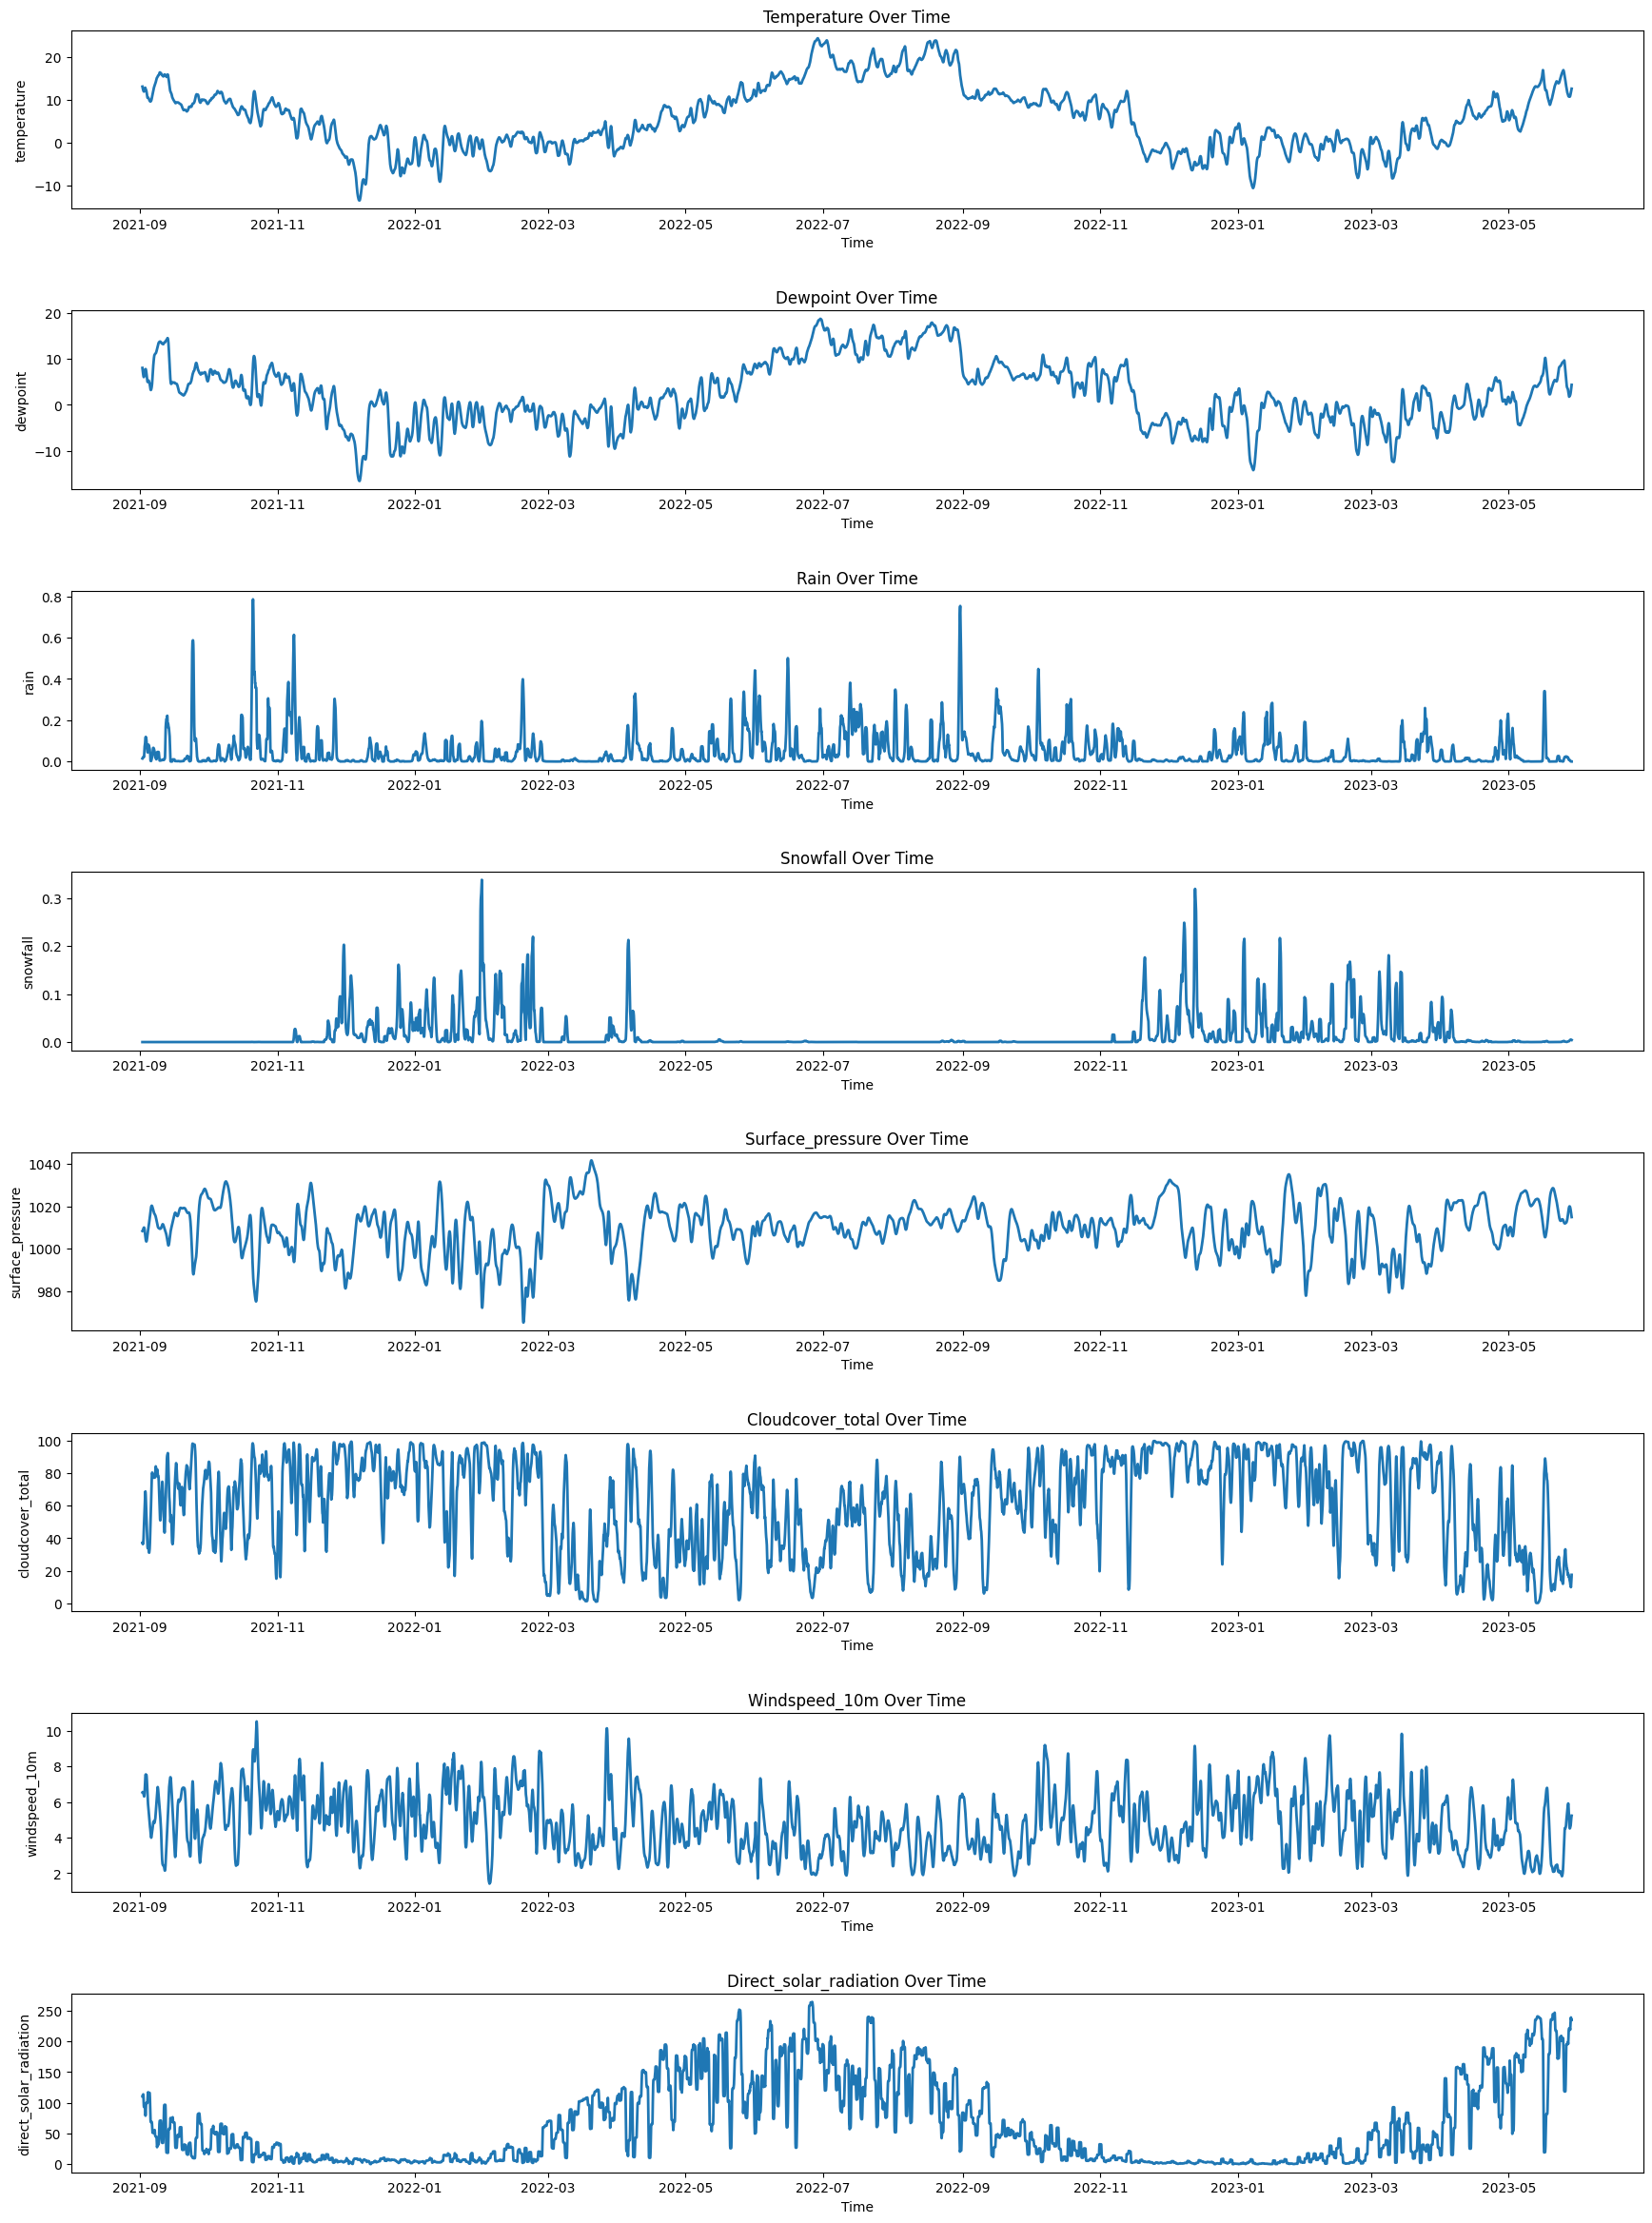

In [28]:
columns_of_interest = [
    'temperature', 'dewpoint', 'rain', 'snowfall',
    'surface_pressure', 'cloudcover_total', 'windspeed_10m', 'direct_solar_radiation'
]

column_data = final_df.rolling(window=24).mean()  # Apply rolling mean with a 24-hour window

fig, axs = plt.subplots(len(columns_of_interest), 1, figsize=(18, 24))

for i, column in enumerate(columns_of_interest):
    axs[i].plot(column_data.index, column_data[column], linewidth=2)
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel(column)
    axs[i].set_title(f'{column.capitalize()} Over Time')
    axs[i].grid(False)

plt.tight_layout(pad=3.0)  # Adjust padding to ensure titles, labels, and ticks don't overlap
plt.show()


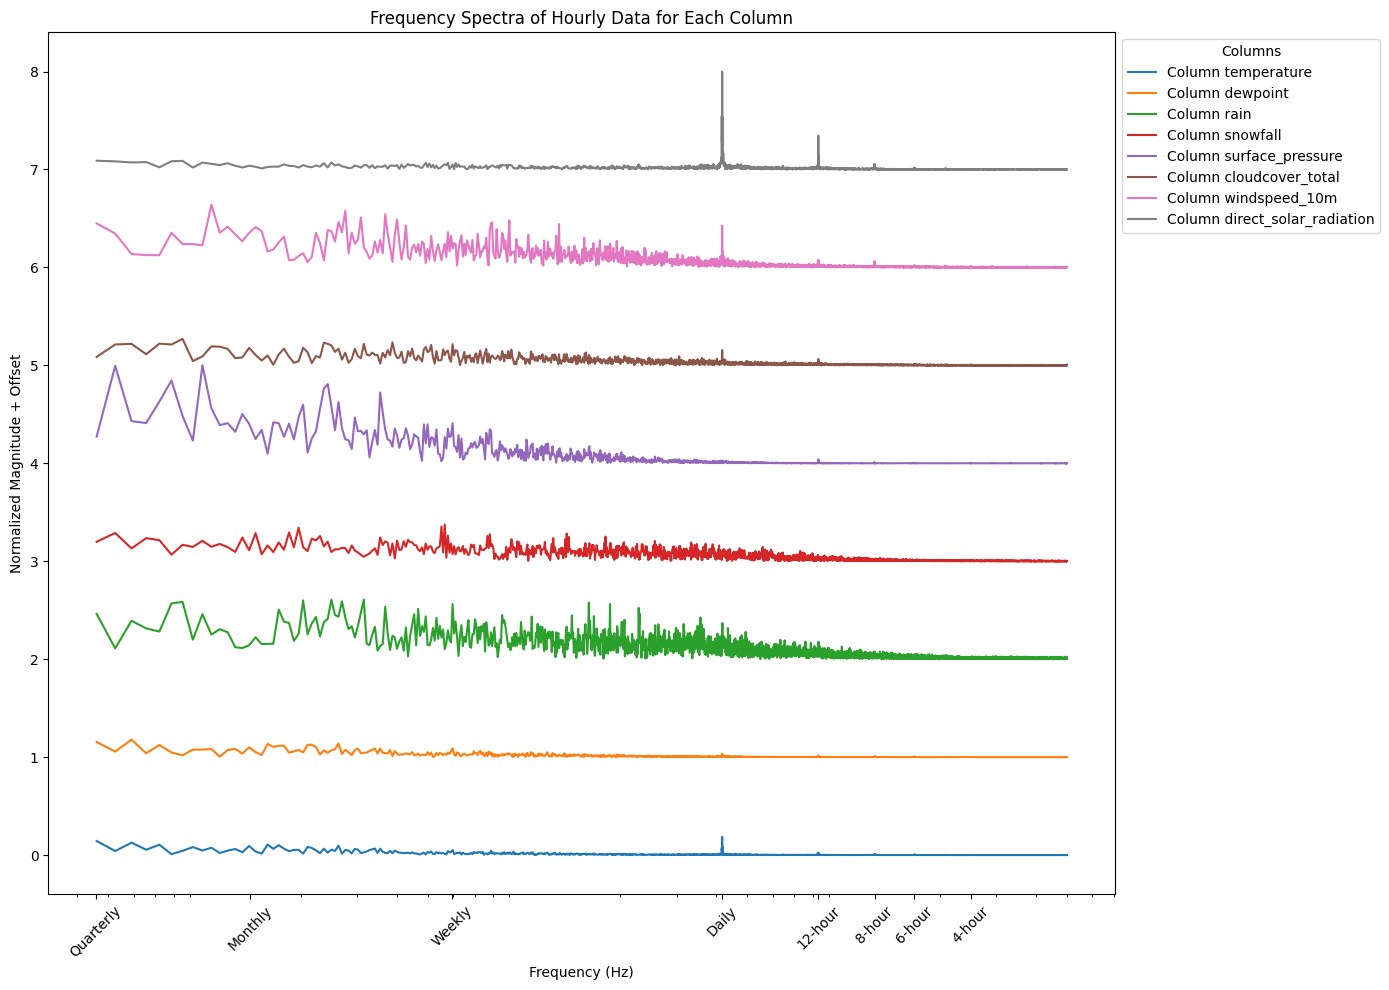

In [29]:
#temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,windspeed_10m,direct_solar_radiation

columns_of_interest = final_df[['temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure', 'cloudcover_total', 'windspeed_10m', 'direct_solar_radiation']].columns

plt.figure(figsize=(14, 10))
plt.xscale('log')

for i, column in enumerate(columns_of_interest):
    column_data = final_df[column].dropna()  # Ensure there are no NaN values
    fft_values = np.fft.fft(column_data)
    frequencies = np.fft.fftfreq(len(fft_values), d=1)  # d=1 because data is hourly
    magnitudes = np.abs(fft_values)[frequencies > 0]
    normalized_magnitudes = magnitudes / np.max(magnitudes)
    positive_freqs = frequencies[frequencies > 0]

    # Adjust the filtering based on updated frequencies for periods
    valid_freqs = positive_freqs[positive_freqs > frequencies_for_periods['Quarterly']]
    valid_magnitudes = normalized_magnitudes[positive_freqs > frequencies_for_periods['Quarterly']]

    offset_magnitudes = valid_magnitudes + i  # Offset for clarity

    plt.plot(valid_freqs, offset_magnitudes, label=f'Column {column}')

plt.title('Frequency Spectra of Hourly Data for Each Column')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Normalized Magnitude + Offset')
plt.xticks(list(frequencies_for_periods.values()), list(frequencies_for_periods.keys()), rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Columns')
plt.tight_layout()
plt.show()

# feature engineering
* **workday vs weekend**
* **day vs night** - whether there is daylight or not = if 0, production should also be 0
* **projected production** 
* capacity per client

In [5]:
final_df['hour'] = final_df.index.hour
final_df['month'] = final_df.index.month
final_df['day'] = final_df.index.weekday + 1
final_df['target_production'] = final_df['installed_capacity'] * final_df['direct_solar_radiation'] / (final_df['temperature'] + 273.15)
final_df["capacity_per_eic"] = np.round(final_df["installed_capacity"] / final_df["eic_count"], 2)
final_df['Weekday'] = [0 if day > 4 else 1 for day in final_df.index.dayofweek]
final_df['Weekday'] = final_df['Weekday'].astype('int64')  # Explicitly cast to int64


In [6]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15232 entries, 2021-09-01 07:00:00 to 2023-05-29 00:00:00
Data columns (total 47 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   target                                            15232 non-null  float64
 1   demand                                            15232 non-null  float64
 2   supply                                            15232 non-null  float64
 3   eic_count                                         15232 non-null  int64  
 4   installed_capacity                                15232 non-null  float64
 5   is_business                                       15232 non-null  int64  
 6   product_type_0                                    15232 non-null  int64  
 7   product_type_1                                    15232 non-null  int64  
 8   product_type_2                                    15232 non-n

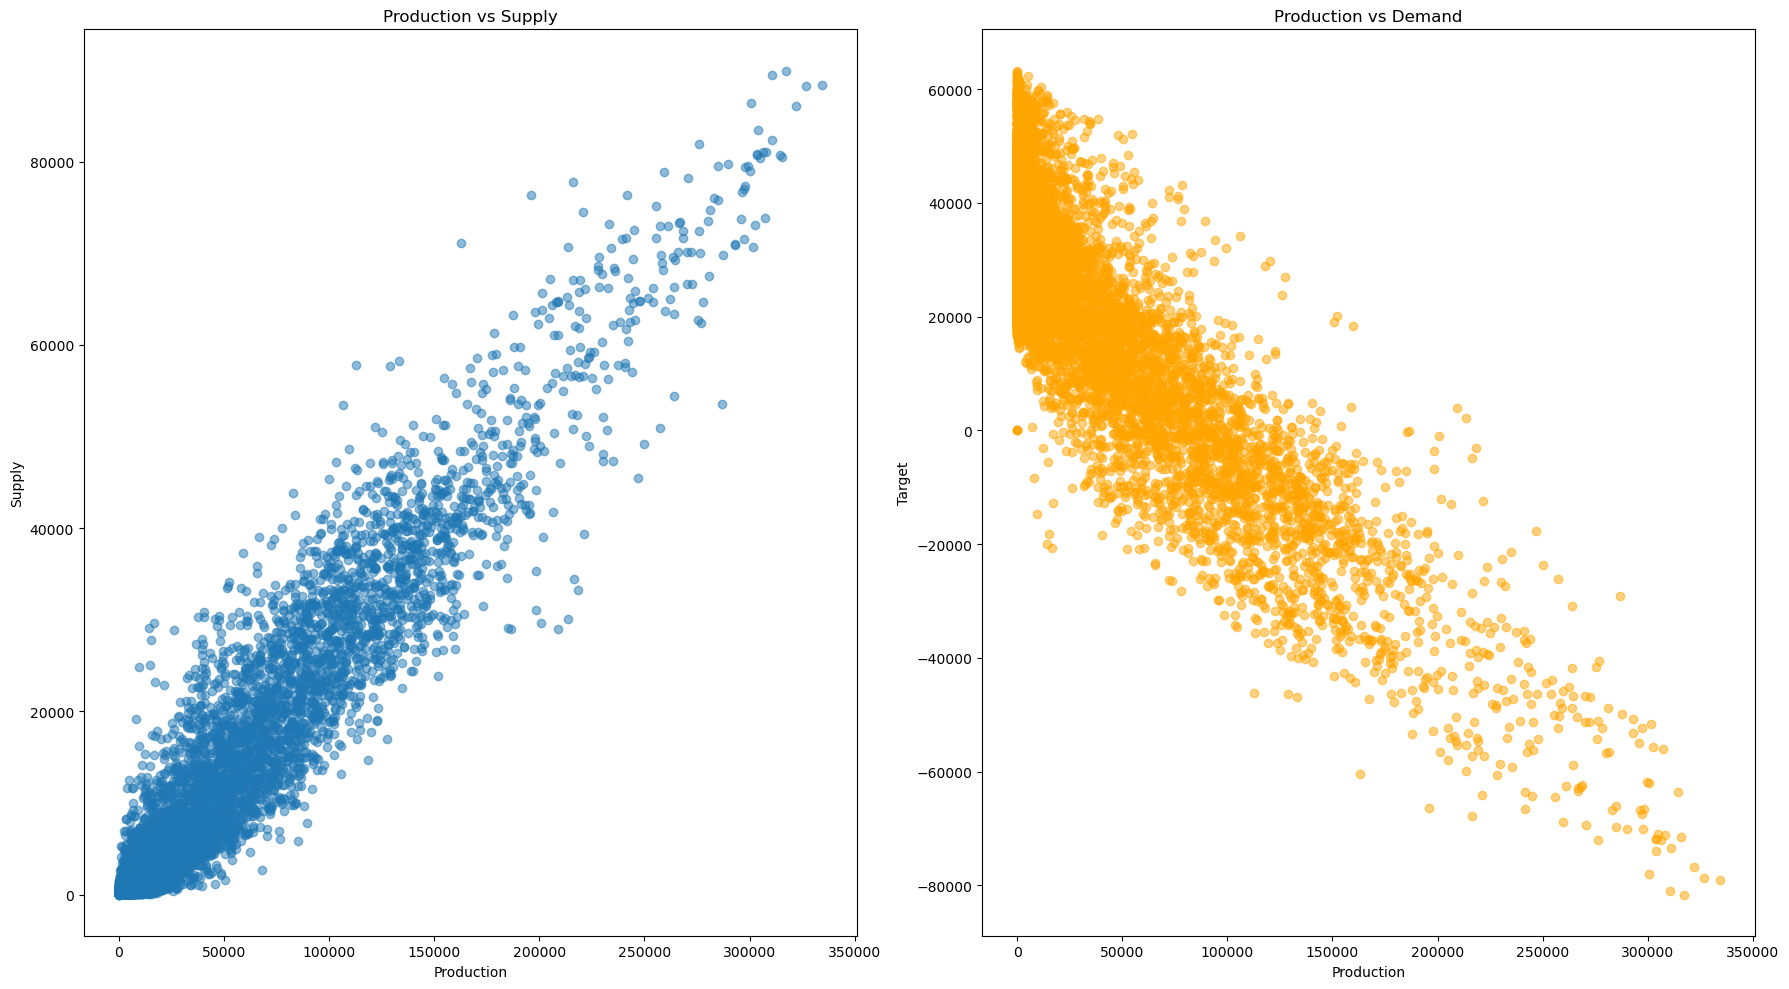

                   target_production    supply
target_production           1.000000  0.964791
supply                      0.964791  1.000000
                   target_production    demand
target_production           1.000000 -0.411568
demand                     -0.411568  1.000000


In [19]:
series_production = final_df['target_production']
series_supply = final_df['supply']
series_demand = final_df['demand']
series_target = final_df['target']

#plot correlation graph of supply and target over production
fig, axs = plt.subplots(1, 2, figsize=(18, 10))

axs[0].scatter(series_production, series_supply, alpha=0.5)
axs[0].set_title('Production vs Supply')
axs[0].set_xlabel('Production')
axs[0].set_ylabel('Supply')

# Scatter plot for Production vs Target
axs[1].scatter(series_production, series_target, alpha=0.5, color='orange')
axs[1].set_title('Production vs Demand')
axs[1].set_xlabel('Production')
axs[1].set_ylabel('Target')

plt.tight_layout()
plt.show()

#pearsons correlation for production and supply
correlation = final_df[['target_production', 'supply']].corr(method='pearson')
print(correlation)

#pearsons correlation for production and target
correlation = final_df[['target_production', 'demand']].corr(method='pearson')
print(correlation)


# Data Cleaning

In [20]:
# drop rows - will not affect model
# 24  lowest_price_per_mwh                              15239 non-null  float64
# 25  highest_price_per_mwh                             15239 non-null  float64
# 26  euros_per_mwh  
# year column

# final_df = final_df.drop(columns=['lowest_price_per_mwh', 'highest_price_per_mwh', 'euros_per_mwh'])

# xgboost (without feature selection)

In [55]:
def split_series(df, n_past, n_future, target_column_name, feature_column_names):
    """
    Split a DataFrame into past features and future target arrays.

    Parameters:
    - df: DataFrame containing the time series data.
    - n_past: Number of past observations to use for predicting the future.
    - n_future: Number of future observations to predict.
    - target_column_name: Name of the target column.
    - feature_column_names: List of column names to be used as features.
    - scaling: if dataset is scaled REMOVED

    Returns:
    - X: Array of past observations' features.
    - y: Array of future observations' target values.
    Only if scaling is true:
    - feature_scaler: scaler for X REMOVED
    - target_scaler: scaler for y REMOVED
    """

    # if scaling == 1:
    #     feature_scaler = MinMaxScaler()
    #     target_scaler = MinMaxScaler()
        
    #     # Fit the scalers
    #     feature_scaler.fit(df[feature_column_names])
    #     target_scaler.fit(df[[target_column_name]])
        
    #     # Apply the transformations
    #     scaled_features = feature_scaler.transform(df[feature_column_names])
    #     scaled_target = target_scaler.transform(df[[target_column_name]])

    X, y = list(), list()
    for window_start in range(len(df)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(df):
            break
        # Select the columns by name for the past and future segments
        # if scaling == 1:
        #     past = scaled_features[window_start:past_end]
        #     future = scaled_target[past_end:future_end]
        past = df.iloc[window_start:past_end][feature_column_names].values
        future = df.iloc[past_end:future_end][target_column_name].values
        X.append(past)
        y.append(future)
    X, y = np.array(X), np.array(y)
    print(f"X shape: {X.shape}, y shape: {y.shape}")
    # if scaling == 1:
    #     return X, y, feature_scaler, target_scaler
    return X, y

def reformat_predictions_actual(pred, org_X_train):
       '''
       Converts the diff predictions into the original values, returns actual predictions and original values
       y_train[1:,:] + org_y_train[0:-1,:] == org_y_train[1]
       '''
       final_predictions = np.zeros_like(pred)

       for i in range(pred.shape[0]):  # Loop over rows
            final_predictions[i, 0] = org_X_train[i, -1] + pred[i, 0]
            for j in range(1, pred.shape[1]):  # Adjusted to pred's shape for safety
                # Ensure you don't exceed bounds, assuming pred and final_predictions are aligned
                if j < final_predictions.shape[1]:
                    final_predictions[i, j] = final_predictions[i, j-1] + pred[i, j]
                else:
                    break  # Stop if you're about to exceed bounds
       return final_predictions

In [165]:
df = final_df.copy()

In [57]:
from sklearn.preprocessing import MinMaxScaler

n_past = 48
n_future = 24
target_column_name = 'diff_demand'
train_df, val_df, test_df = df[1:int(len(df)*0.8)], df[int(len(df)*0.8):int(len(df)*0.8)+int(len(df)*0.1)], df[int(len(df)*0.8)+int(len(df)*0.1):] 
feature_column_names = train_df.drop(columns=['target', 'supply', 'diff_supply', 'demand']).columns

# feature_column_names = ['target', 'eic_count','forecasted_temperature','forecasted_direct_solar_radiation','forecasted_surface_solar_radiation_downwards','hour','month','day']

dataframe_scaler = MinMaxScaler()
dataframe_scaler = dataframe_scaler.fit(train_df)
inverse_scaler = MinMaxScaler()
inverse_scaler = inverse_scaler.fit(train_df[[target_column_name]])

scaled_train_df = pd.DataFrame(dataframe_scaler.transform(train_df), columns = train_df.columns)
scaled_val_df = pd.DataFrame(dataframe_scaler.transform(val_df), columns = val_df.columns)
scaled_test_df = pd.DataFrame(dataframe_scaler.transform(test_df), columns = test_df.columns)

scaled_X_train, scaled_y_train = split_series(scaled_train_df,n_past, n_future, target_column_name, feature_column_names)
scaled_X_val, scaled_y_val = split_series(scaled_val_df,n_past, n_future, target_column_name, feature_column_names)
scaled_X_test, scaled_y_test = split_series(scaled_test_df,n_past, n_future, target_column_name, feature_column_names)

# for xgboost - 
X_train, y_train = split_series(train_df,n_past, n_future, target_column_name, feature_column_names)
X_val, y_val = split_series(val_df,n_past, n_future, target_column_name, feature_column_names)
X_test, y_test = split_series(test_df,n_past, n_future, target_column_name, feature_column_names)

ARIMA_X_train, ARIMA_y_train = split_series(train_df,365, n_future, target_column_name, target_column_name)
ARIMA_X_val, ARIMA_y_val = split_series(val_df,365, n_future, target_column_name, target_column_name)
ARIMA_X_test, ARIMA_y_test = split_series(test_df,365, n_future, target_column_name, target_column_name)

org_X_train, org_y_train = split_series(train_df,n_past, n_future, 'demand', 'demand')
org_X_val, org_y_val = split_series(val_df,n_past, n_future, 'demand', 'demand')
org_X_test, org_y_test = split_series(test_df,n_past, n_future, 'demand', 'demand')

X shape: (12112, 48, 43), y shape: (12112, 24)
X shape: (1452, 48, 43), y shape: (1452, 24)
X shape: (1453, 48, 43), y shape: (1453, 24)
X shape: (12112, 48, 43), y shape: (12112, 24)
X shape: (1452, 48, 43), y shape: (1452, 24)
X shape: (1453, 48, 43), y shape: (1453, 24)
X shape: (11795, 365), y shape: (11795, 24)
X shape: (1135, 365), y shape: (1135, 24)
X shape: (1136, 365), y shape: (1136, 24)
X shape: (12112, 48), y shape: (12112, 24)
X shape: (1452, 48), y shape: (1452, 24)
X shape: (1453, 48), y shape: (1453, 24)


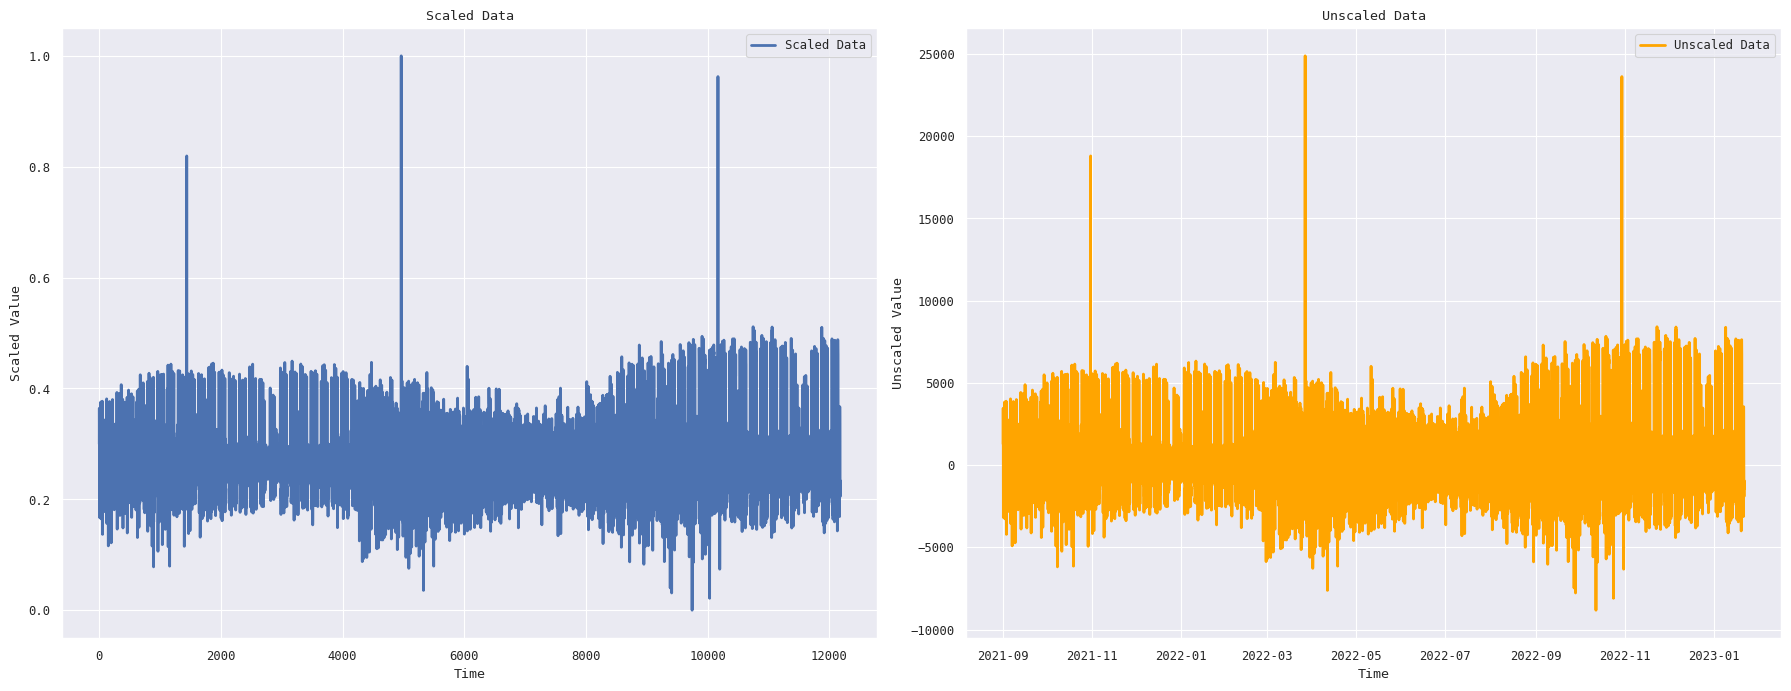

In [166]:
from sklearn.preprocessing import MinMaxScaler

n_past = 48
n_future = 24
target_column_name = 'diff_demand'
train_df, val_df, test_df = df[1:int(len(df)*0.8)], df[int(len(df)*0.8):int(len(df)*0.8)+int(len(df)*0.1)], df[int(len(df)*0.8)+int(len(df)*0.1):] 
feature_column_names = train_df.drop(columns=['target', 'supply', 'diff_supply', 'demand']).columns

# feature_column_names = ['target', 'eic_count','forecasted_temperature','forecasted_direct_solar_radiation','forecasted_surface_solar_radiation_downwards','hour','month','day']

dataframe_scaler = MinMaxScaler()
dataframe_scaler = dataframe_scaler.fit(train_df)
inverse_scaler = MinMaxScaler()
inverse_scaler = inverse_scaler.fit(train_df[[target_column_name]])

scaled_train_df = pd.DataFrame(dataframe_scaler.transform(train_df), columns = train_df.columns)
scaled_val_df = pd.DataFrame(dataframe_scaler.transform(val_df), columns = val_df.columns)
scaled_test_df = pd.DataFrame(dataframe_scaler.transform(test_df), columns = test_df.columns)

# compare scaled vs non scaled data in a plot
fig, axs = plt.subplots(1, 2, figsize=(18, 7))

# Plot for Scaled Data
axs[0].plot(scaled_train_df.index, scaled_train_df[target_column_name], label='Scaled Data', linewidth=2)
axs[0].set_title('Scaled Data')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Scaled Value')
axs[0].legend()

# Plot for Unscaled Data
axs[1].plot(train_df.index, train_df[target_column_name], label='Unscaled Data', linewidth=2, color='orange')
axs[1].set_title('Unscaled Data')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Unscaled Value')
axs[1].legend()

plt.tight_layout()
plt.show()

In [58]:
import xgboost as xgb

X_train_flat = X_train.reshape(X_train.shape[0], -1)  
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [59]:
#xgbmodel = xgb.XGBRegressor(objective='reg:squarederror', max_depth=3, early_stopping_rounds=10, eta=0.1)
#quick runtime test
xgbmodel = xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=2,
    n_estimators=50,  
    learning_rate=0.1,
    verbosity=0
)

xgbmodel.fit(X_train_flat, y_train, eval_set=[(X_train_flat, y_train), (X_val_flat, y_val)])


[0]	validation_0-rmse:1951.52614	validation_1-rmse:2581.88011
[1]	validation_0-rmse:1864.67944	validation_1-rmse:2475.07531
[2]	validation_0-rmse:1790.60380	validation_1-rmse:2380.15676
[3]	validation_0-rmse:1725.60809	validation_1-rmse:2298.69607
[4]	validation_0-rmse:1670.49605	validation_1-rmse:2221.54390
[5]	validation_0-rmse:1622.25532	validation_1-rmse:2157.70135
[6]	validation_0-rmse:1576.59229	validation_1-rmse:2100.62695
[7]	validation_0-rmse:1535.44230	validation_1-rmse:2049.04751
[8]	validation_0-rmse:1500.96102	validation_1-rmse:2003.66563
[9]	validation_0-rmse:1473.11242	validation_1-rmse:1963.06591
[10]	validation_0-rmse:1441.98454	validation_1-rmse:1926.98762
[11]	validation_0-rmse:1419.85671	validation_1-rmse:1897.16777
[12]	validation_0-rmse:1395.99528	validation_1-rmse:1867.97817
[13]	validation_0-rmse:1376.26053	validation_1-rmse:1840.10444
[14]	validation_0-rmse:1357.04044	validation_1-rmse:1813.87205
[15]	validation_0-rmse:1341.81849	validation_1-rmse:1794.20313
[1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

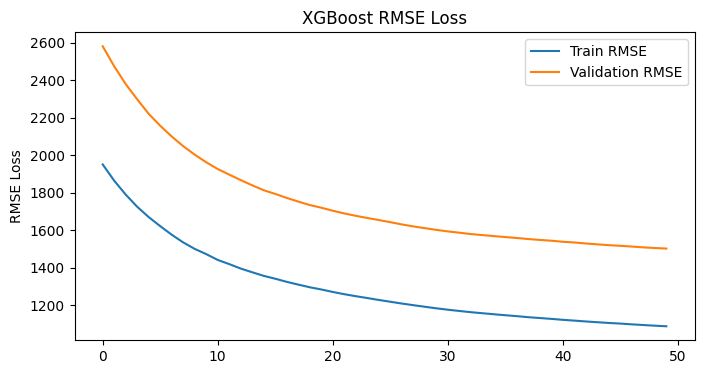

In [63]:
results = xgbmodel.evals_result()
train_mae, val_mae = results["validation_0"]["rmse"], results["validation_1"]["rmse"]
x_values = range(0, len(train_mae))
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(x_values, train_mae, label="Train RMSE")
ax.plot(x_values, val_mae, label="Validation RMSE")
ax.legend()
plt.ylabel("RMSE Loss")
plt.title("XGBoost RMSE Loss")
plt.show()

In [64]:
train_pred = xgbmodel.predict(X_train_flat)
val_pred = xgbmodel.predict(X_val_flat)
test_pred = xgbmodel.predict(X_test_flat)

xg_y_train_pred = reformat_predictions_actual(train_pred, org_X_train)
xg_y_val_pred = reformat_predictions_actual(val_pred, org_X_val)
xg_y_test_pred = reformat_predictions_actual(test_pred, org_X_test)

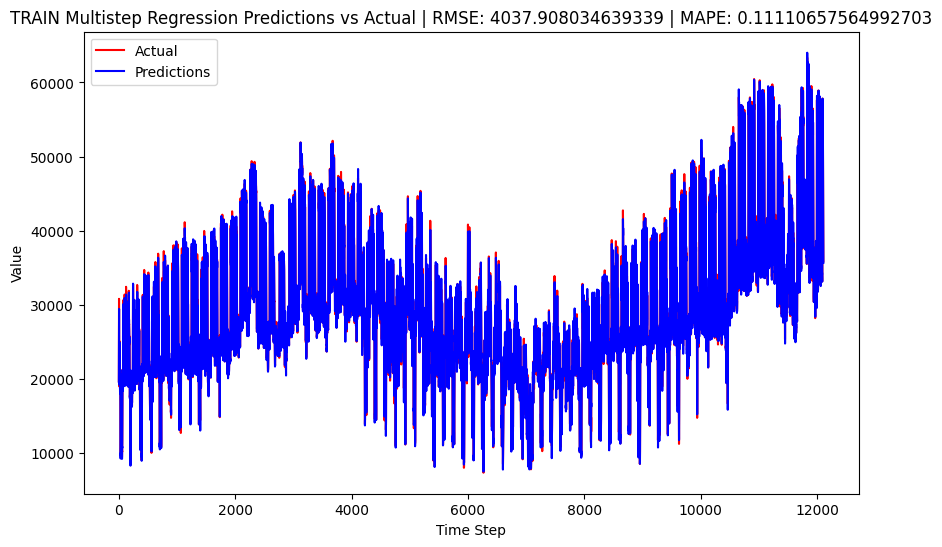

In [65]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

plt.figure(figsize=(10, 6))
plt.plot(org_y_train[:,0], label='Actual', color='red')
plt.plot(xg_y_train_pred[:,0], label='Predictions', color='blue')

plt.title(f'TRAIN Multistep Regression Predictions vs Actual | RMSE: {np.sqrt(mean_squared_error(org_y_train, xg_y_train_pred))} | MAPE: {mean_absolute_percentage_error(org_y_train+1, xg_y_train_pred+1)}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

# Feature Selection

* drop rows w no contextual importance
* RFE feature selection with xgboost estimator 
* RFE feature selection with random forest predictive model

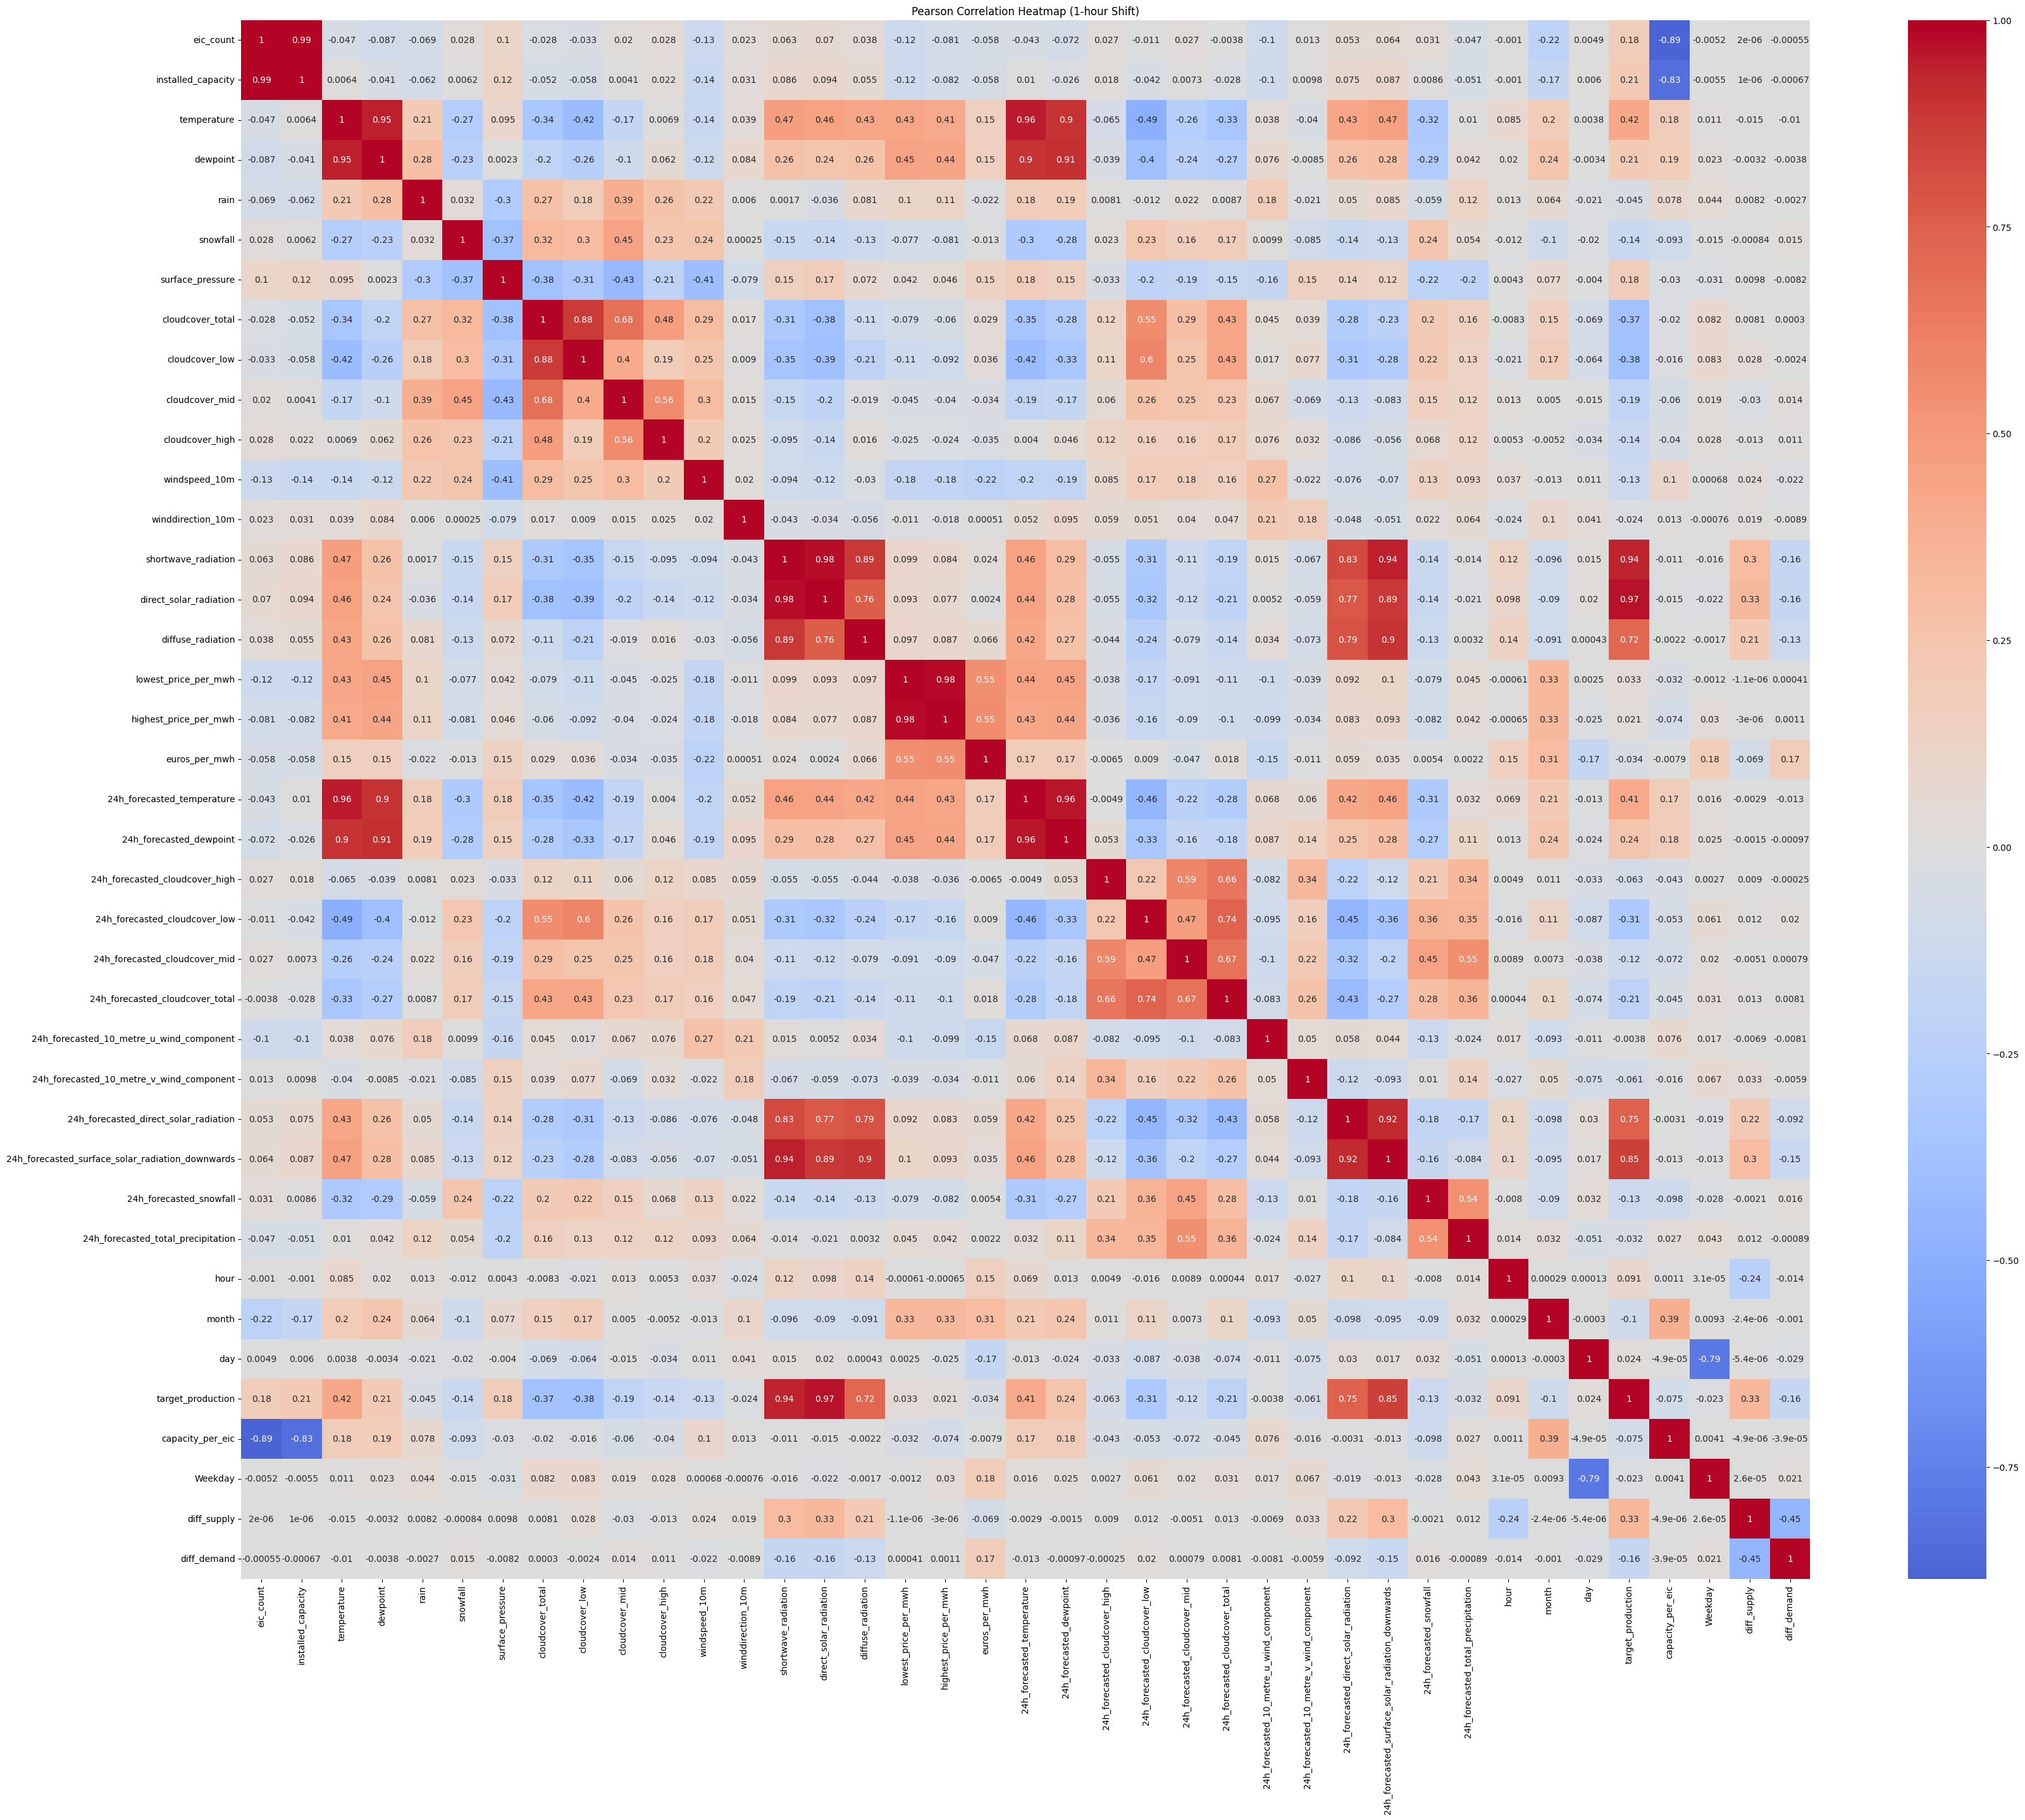

In [7]:
#changed to pearson, shifted the items by 1 periods

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

columns_to_shift = final_df.drop(['target', 'supply', 'demand', 'diff_supply', 'diff_demand','is_business','product_type_0','product_type_1','product_type_2','product_type_3'], axis=1)
shifted_df = columns_to_shift.shift(periods=-1)
combined_df = pd.concat([shifted_df, final_df[['diff_supply', 'diff_demand']]], axis=1)
corr_shifted = combined_df.corr(method='pearson')

plt.figure(figsize=(40, 32))
sns.heatmap(corr_shifted, annot=True, cmap='coolwarm', center=0)
plt.title('Pearson Correlation Heatmap (1-hour Shift)')
plt.show()


In [8]:

# filtered_df = final_df.drop(['target', 'supply', 'demand', 'diff_supply', 'diff_demand','is_business','product_type_0','product_type_1','product_type_2','product_type_3'], axis=1)
# spearman_corr = filtered_df.corr(method='spearman')

# # Create a heatmap for the Spearman's correlation matrix
# plt.figure(figsize=(20, 16))
# sns.heatmap(spearman_corr, annot=False, cmap='coolwarm', center=0)
# plt.title('Spearman Correlation Heatmap')
# plt.show()


In [9]:
def remove_collinear_features(x, threshold, protected_vars=[]):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold, while protecting specified variables from being removed.
        Removing collinear features can help a model to generalize and improves the interpretability
        of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed
        protected_vars: list of variable names that should not be dropped

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''
    corr_matrix = x.corr(method='pearson')
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    for i in iters:
        for j in range(i):
            # Here 'i' is the index of the column to the right (later in the DataFrame)
            # 'j' is the index of the column to the left (earlier in the DataFrame)
            if abs(corr_matrix.iloc[j, i]) >= threshold:
                # If either of the columns in the pair is protected, we skip dropping
                if corr_matrix.columns[i] not in protected_vars:
                    drop_cols.append(corr_matrix.columns[i])
                elif corr_matrix.columns[j] not in protected_vars:
                    drop_cols.append(corr_matrix.columns[j])
                    
    drops = set(drop_cols) - set(protected_vars)
    x = x.drop(columns=drops)
    print('Removed Columns {}'.format(drops))
    return x


In [10]:
filtered_df = remove_collinear_features(final_df.drop(['target', 'supply', 'demand','is_business','product_type_0','product_type_1','product_type_2','product_type_3'],axis=1),0.9,['capacity_per_eic','target_production'])

filtered_df.head()

Removed Columns {'dewpoint', 'shortwave_radiation', '24h_forecasted_temperature', 'direct_solar_radiation', 'highest_price_per_mwh', '24h_forecasted_surface_solar_radiation_downwards', 'installed_capacity', '24h_forecasted_dewpoint'}


eic_count  temperature      rain  snowfall  \
datetime                                                          
2021-09-01 07:00:00       3159    13.047321  0.000000       0.0   
2021-09-01 08:00:00       3159    13.675000  0.000000       0.0   
2021-09-01 09:00:00       3159    14.053571  0.006250       0.0   
2021-09-01 10:00:00       3159    14.453571  0.023214       0.0   
2021-09-01 11:00:00       3159    14.741071  0.033929       0.0   

                     surface_pressure  cloudcover_total  cloudcover_low  \
datetime                                                                  
2021-09-01 07:00:00       1008.350000         27.767857       19.044643   
2021-09-01 08:00:00       1008.260714         32.187500       22.446429   
2021-09-01 09:00:00       1008.299107         33.776786       21.571429   
2021-09-01 10:00:00       1008.282143         38.142857       22.383929   
2021-09-01 11:00:00       1008.181250         40.883929       23.616071   

                     cloudcover_mid  cloudcover_high  windspeed_10m  ...  \
datetime                                                             ...   
2021-09-01 07:00:00        6.910714        21.482143       5.675099  ...   
2021-09-01 08:00:00        8.035714        24.232143       6.193948  ...   
2021-09-01 09:00:00       10.375000        27.071429       6.324157  ...   
2021-09-01 10:00:00       16.008929        29.526786       6.534226  ...   
2021-09-01 11:00:00       20.500000        26.375000       6.917411  ...   

                     24h_forecasted_snowfall  \
datetime                                       
2021-09-01 07:00:00                      0.0   
2021-09-01 08:00:00                      0.0   
2021-09-01 09:00:00                      0.0   
2021-09-01 10:00:00                      0.0   
2021-09-01 11:00:00                      0.0   

                     24h_forecasted_total_precipitation  diff_demand  \
datetime                                                               
2021-09-01 07:00:00                            0.000024     2469.043   
2021-09-01 08:00:00                            0.000024      432.682   
2021-09-01 09:00:00                            0.000024    -3186.227   
2021-09-01 10:00:00                            0.000034    -2788.827   
2021-09-01 11:00:00                            0.000024    -1956.213   

                     diff_supply  hour  month  day  target_production  \
datetime                                                                
2021-09-01 07:00:00     1071.039     7      9    3        9531.717947   
2021-09-01 08:00:00     3522.363     8      9    3       26973.095385   
2021-09-01 09:00:00     5940.290     9      9    3       46006.675872   
2021-09-01 10:00:00     6312.074    10      9    3       59819.382465   
2021-09-01 11:00:00     4989.303    11      9    3       65992.003289   

                     capacity_per_eic  Weekday  
datetime                                        
2021-09-01 07:00:00             22.37        1  
2021-09-01 08:00:00             22.37        1  
2021-09-01 09:00:00             22.37        1  
2021-09-01 10:00:00             22.37        1  
2021-09-01 11:00:00             22.37        1  

[5 rows x 31 columns]

In [11]:
def split_series(df, n_past, n_future, target_column_name, feature_column_names):
    """
    Split a DataFrame into past features and future target arrays.

    Parameters:
    - df: DataFrame containing the time series data.
    - n_past: Number of past observations to use for predicting the future.
    - n_future: Number of future observations to predict.
    - target_column_name: Name of the target column.
    - feature_column_names: List of column names to be used as features.
    - scaling: if dataset is scaled REMOVED

    Returns:
    - X: Array of past observations' features.
    - y: Array of future observations' target values.
    Only if scaling is true:
    - feature_scaler: scaler for X REMOVED
    - target_scaler: scaler for y REMOVED
    """

    # if scaling == 1:
    #     feature_scaler = MinMaxScaler()
    #     target_scaler = MinMaxScaler()
        
    #     # Fit the scalers
    #     feature_scaler.fit(df[feature_column_names])
    #     target_scaler.fit(df[[target_column_name]])
        
    #     # Apply the transformations
    #     scaled_features = feature_scaler.transform(df[feature_column_names])
    #     scaled_target = target_scaler.transform(df[[target_column_name]])

    X, y = list(), list()
    for window_start in range(len(df)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(df):
            break
        # Select the columns by name for the past and future segments
        # if scaling == 1:
        #     past = scaled_features[window_start:past_end]
        #     future = scaled_target[past_end:future_end]
        past = df.iloc[window_start:past_end][feature_column_names].values
        future = df.iloc[past_end:future_end][target_column_name].values
        X.append(past)
        y.append(future)
    X, y = np.array(X), np.array(y)
    print(f"X shape: {X.shape}, y shape: {y.shape}")
    # if scaling == 1:
    #     return X, y, feature_scaler, target_scaler
    return X, y



## demand RFE

X shape: (10651, 6, 30), y shape: (10651, 6)
Fitting estimator with 180 features.
Fitting estimator with 179 features.
Fitting estimator with 178 features.
Fitting estimator with 177 features.
Fitting estimator with 176 features.
Fitting estimator with 175 features.
Fitting estimator with 174 features.
Fitting estimator with 173 features.
Fitting estimator with 172 features.
Fitting estimator with 171 features.
Fitting estimator with 170 features.
Fitting estimator with 169 features.
Fitting estimator with 168 features.
Fitting estimator with 167 features.
Fitting estimator with 166 features.
Fitting estimator with 165 features.
Fitting estimator with 164 features.
Fitting estimator with 163 features.
Fitting estimator with 162 features.
Fitting estimator with 161 features.
Fitting estimator with 160 features.
Fitting estimator with 159 features.
Fitting estimator with 158 features.
Fitting estimator with 157 features.
Fitting estimator with 156 features.
Fitting estimator with 155 fea

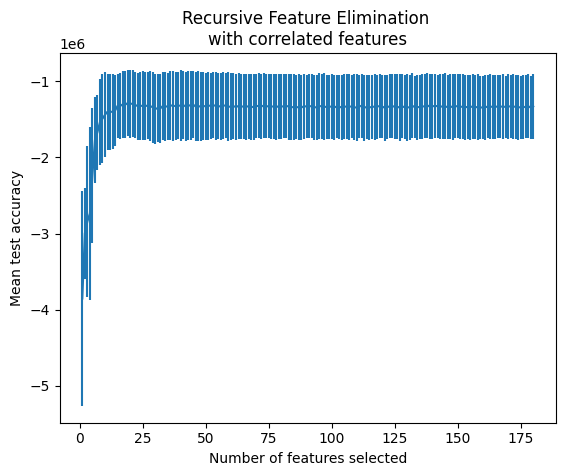

Optimal number of features : 19
Selected Features:
eic_count
diff_demand
hour
diffuse_radiation
cloudcover_total
cloudcover_low
target_production
24h_forecasted_direct_solar_radiation
day
Weekday


In [33]:
# DEMAND
#RFECV with timeseriessplit

from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
filtered_df_demand = filtered_df.drop(columns = ['diff_supply'])
train_X, train_y = split_series(filtered_df_demand[:int(len(filtered_df_demand)*0.7)], 6, 6, 'diff_demand', filtered_df_demand.columns)
X_train_flat = train_X.reshape(train_X.shape[0], -1)
y_train_flat = train_y.reshape(train_y.shape[0], -1)

tscv = TimeSeriesSplit(n_splits=5)

rfecv = RFECV(estimator=RandomForestRegressor(n_estimators=100, n_jobs=-1), step=1, cv=tscv, scoring='neg_mean_squared_error', verbose=1)
# rfecv = RFECV(estimator = LinearRegression(n_jobs=-1), step=1, cv=tscv, scoring='neg_mean_squared_error')

fit = rfecv.fit(X_train_flat, y_train_flat)

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(1, n_scores + 1),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

print(f"Optimal number of features : {rfecv.n_features_}")

print('Selected Features:')
selected_features =[]
names = filtered_df_demand.columns.values
selected_features = []
for i in range(len(fit.support_)):
    if fit.support_[i]:
        if (names[((i+1)%len(names))-1] not in selected_features): 
            selected_features.append(names[((i+1)%len(names))-1]) 
            print(names[((i+1)%len(names))-1])
# selected_features = [names[i] for i in range(len(fit.support_)) if fit.support_[i]]

In [35]:
selected_features

['eic_count',
 '24h_forecasted_cloudcover_low',
 'diff_supply',
 'hour',
 'cloudcover_low',
 'target_production',
 'cloudcover_total',
 'diffuse_radiation',
 '24h_forecasted_direct_solar_radiation']

X shape: (10651, 6, 30), y shape: (10651, 6)
Fitting estimator with 180 features.
Fitting estimator with 179 features.
Fitting estimator with 178 features.
Fitting estimator with 177 features.
Fitting estimator with 176 features.
Fitting estimator with 175 features.
Fitting estimator with 174 features.
Fitting estimator with 173 features.
Fitting estimator with 172 features.
Fitting estimator with 171 features.
Fitting estimator with 170 features.
Fitting estimator with 169 features.
Fitting estimator with 168 features.
Fitting estimator with 167 features.
Fitting estimator with 166 features.
Fitting estimator with 165 features.
Fitting estimator with 164 features.
Fitting estimator with 163 features.
Fitting estimator with 162 features.
Fitting estimator with 161 features.
Fitting estimator with 160 features.
Fitting estimator with 159 features.
Fitting estimator with 158 features.
Fitting estimator with 157 features.
Fitting estimator with 156 features.
Fitting estimator with 155 fea

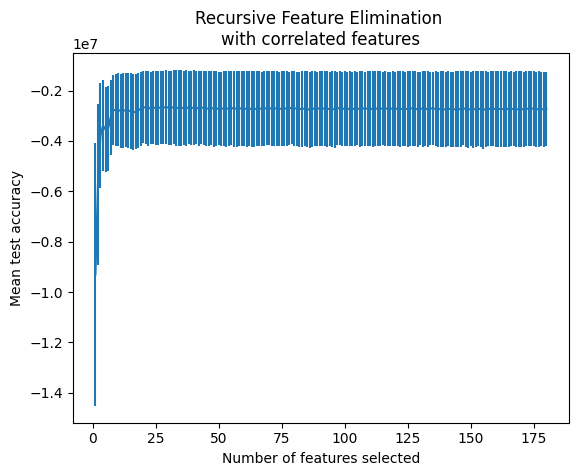

Optimal number of features : 20
Selected Features:
eic_count
24h_forecasted_cloudcover_low
diff_supply
hour
cloudcover_low
target_production
cloudcover_total
diffuse_radiation
24h_forecasted_direct_solar_radiation


In [34]:
# SUPPLY
#RFECV with timeseriessplit

from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
filtered_df_demand = filtered_df.drop(columns = ['diff_demand'])
train_X, train_y = split_series(filtered_df_demand[:int(len(filtered_df_demand)*0.7)], 6, 6, 'diff_supply', filtered_df_demand.columns)
X_train_flat = train_X.reshape(train_X.shape[0], -1)
y_train_flat = train_y.reshape(train_y.shape[0], -1)

tscv = TimeSeriesSplit(n_splits=5)

rfecv = RFECV(estimator=RandomForestRegressor(n_estimators=100, n_jobs=-1), step=1, cv=tscv, scoring='neg_mean_squared_error', verbose=1)
# rfecv = RFECV(estimator = LinearRegression(n_jobs=-1), step=1, cv=tscv, scoring='neg_mean_squared_error')

fit = rfecv.fit(X_train_flat, y_train_flat)

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(1, n_scores + 1),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

print(f"Optimal number of features : {rfecv.n_features_}")

print('Selected Features:')
selected_features =[]
names = filtered_df_demand.columns.values
selected_features = []
for i in range(len(fit.support_)):
    if fit.support_[i]:
        if (names[((i+1)%len(names))-1] not in selected_features): 
            selected_features.append(names[((i+1)%len(names))-1]) 
            print(names[((i+1)%len(names))-1])
# selected_features = [names[i] for i in range(len(fit.support_)) if fit.support_[i]]

In [36]:
selected_features

['eic_count',
 '24h_forecasted_cloudcover_low',
 'diff_supply',
 'hour',
 'cloudcover_low',
 'target_production',
 'cloudcover_total',
 'diffuse_radiation',
 '24h_forecasted_direct_solar_radiation']

In [45]:
#demand feature selection
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

filtered_df_demand = filtered_df.drop(columns = ['diff_supply'])
train_X, train_y = split_series(filtered_df_demand[:int(len(filtered_df_demand)*0.8)], 1, 1, 'diff_demand', filtered_df_demand.columns)
X_train_flat = train_X.reshape(train_X.shape[0], -1)
y_train_flat = train_y.ravel()

rfe = RFE(RandomForestRegressor(n_estimators=100, random_state=42), n_features_to_select= 20)
fit = rfe.fit(X_train_flat, y_train_flat)

print('Selected Features:')
selected_features =[]
names = filtered_df_demand.columns.values
for i in range(len(fit.support_)):
    if fit.support_[i]:
        if (names[((i+1)%len(names))-1] not in selected_features): 
            selected_features.append(names[((i+1)%len(names))-1]) 
            print(names[((i+1)%len(names))-1])

# plt.figure(figsize=(10, 6))
# plt.bar(range(train_X.shape[1]), fit.ranking_)
# plt.xticks(range(train_X.shape[1]), names, rotation=90)
# plt.xlabel('Features')
# plt.ylabel('Feature Importance Rank')
# plt.title('Feature Importance Ranking (1 = most important)')
# plt.tight_layout()  
# plt.show()


X shape: (12184, 1, 30), y shape: (12184, 1)
Selected Features:
eic_count
temperature
rain
surface_pressure
cloudcover_total
cloudcover_low
cloudcover_mid
windspeed_10m
diffuse_radiation
lowest_price_per_mwh
euros_per_mwh
24h_forecasted_10_metre_u_wind_component
24h_forecasted_10_metre_v_wind_component
24h_forecasted_direct_solar_radiation
diff_demand
hour
day
target_production
capacity_per_eic
Weekday


hi!


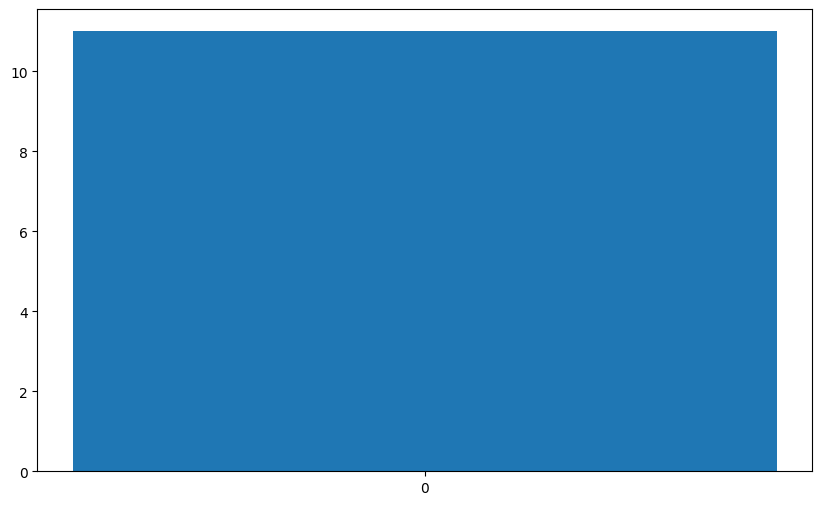

In [43]:
try:
    plt.figure(figsize=(10, 6))
    plt.bar(range(train_X.shape[1]), fit.ranking_)
    plt.xticks(range(train_X.shape[1]), names, rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Feature Importance Rank')
    plt.title('Feature Importance Ranking (1 = most important)')
    plt.tight_layout()  
    plt.show()
except:
    print("hi!")

In [46]:
#demand feature selection
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

filtered_df_demand = filtered_df.drop(columns = ['diff_demand'])
train_X, train_y = split_series(filtered_df_demand[:int(len(filtered_df_demand)*0.8)], 1, 1, 'diff_supply', filtered_df_demand.columns)
X_train_flat = train_X.reshape(train_X.shape[0], -1)
y_train_flat = train_y.ravel()

rfe = RFE(RandomForestRegressor(n_estimators=100, random_state=42), n_features_to_select= 20)
fit = rfe.fit(X_train_flat, y_train_flat)

print('Selected Features:')
selected_features =[]
names = filtered_df_demand.columns.values
for i in range(len(fit.support_)):
    if fit.support_[i]:
        if (names[((i+1)%len(names))-1] not in selected_features): 
            selected_features.append(names[((i+1)%len(names))-1]) 
            print(names[((i+1)%len(names))-1])

# plt.figure(figsize=(10, 6))
# plt.bar(range(train_X.shape[1]), fit.ranking_)
# plt.xticks(range(train_X.shape[1]), names, rotation=90)
# plt.xlabel('Features')
# plt.ylabel('Feature Importance Rank')
# plt.title('Feature Importance Ranking (1 = most important)')
# plt.tight_layout()  
# plt.show()


X shape: (12184, 1, 30), y shape: (12184, 1)
Selected Features:
eic_count
temperature
rain
surface_pressure
cloudcover_total
cloudcover_low
cloudcover_mid
cloudcover_high
windspeed_10m
diffuse_radiation
lowest_price_per_mwh
euros_per_mwh
24h_forecasted_cloudcover_high
24h_forecasted_cloudcover_low
24h_forecasted_10_metre_u_wind_component
24h_forecasted_10_metre_v_wind_component
24h_forecasted_direct_solar_radiation
diff_supply
hour
target_production


In [ ]:
try:
    plt.figure(figsize=(10, 6))
    plt.bar(range(train_X.shape[1]), fit.ranking_)
    plt.xticks(range(train_X.shape[1]), names, rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Feature Importance Rank')
    plt.title('Feature Importance Ranking (1 = most important)')
    plt.tight_layout()  
    plt.show()
except:
    print("hi!")

In [50]:
print('Dropped Features:')
dropped_features = train_X.columns.values[~fit.support_]
print(dropped_features)

Dropped Features:
['eic_count' 'snowfall' 'cloudcover_high' 'windspeed_10m'
 'winddirection_10m' 'lowest_price_per_mwh'
 '24h_forecasted_cloudcover_high' '24h_forecasted_cloudcover_mid'
 '24h_forecasted_cloudcover_total'
 '24h_forecasted_10_metre_u_wind_component' '24h_forecasted_snowfall'
 '24h_forecasted_total_precipitation' 'day' 'month' 'year']


In [51]:
selected_features = train_X.columns[fit.support_]

filtered_df = final_df[list(selected_features) + ['diff_demand'] + ['demand']]

filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15236 entries, 2021-09-01 03:00:00 to 2023-05-29 00:00:00
Data columns (total 22 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   installed_capacity                                15236 non-null  float64
 1   temperature                                       15236 non-null  float64
 2   dewpoint                                          15236 non-null  float64
 3   rain                                              15236 non-null  float64
 4   surface_pressure                                  15236 non-null  float64
 5   cloudcover_total                                  15236 non-null  float64
 6   cloudcover_low                                    15236 non-null  float64
 7   cloudcover_mid                                    15236 non-null  float64
 8   shortwave_radiation                               15236 non-n


## Supply RFE

X shape: (10661, 1, 30), y shape: (10661, 1)


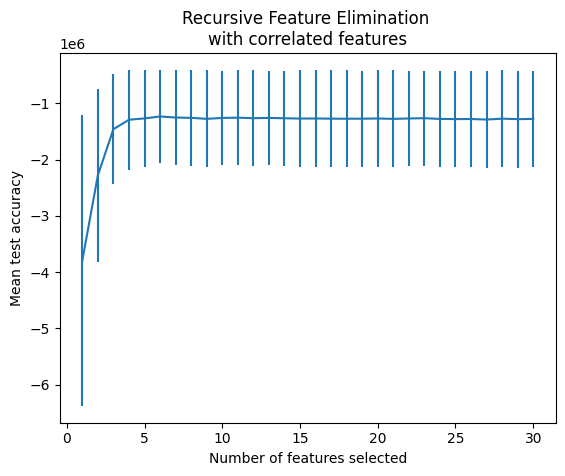

Optimal number of features : 6
Selected Features:
rain
cloudcover_total
diffuse_radiation
diff_supply
hour
target_production


In [13]:
# SUPPLY
#RFECV with timeseriessplit

from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import LinearRegression
filtered_df_supply = filtered_df.drop(columns = ['diff_demand'])
train_X, train_y = split_series(filtered_df_supply[:int(len(filtered_df_supply)*0.7)], 1, 1, 'diff_supply', filtered_df_supply.columns)
X_train_flat = train_X.reshape(train_X.shape[0], -1)
y_train_flat = train_y.ravel()

tscv = TimeSeriesSplit(n_splits=10)

rfecv = RFECV(estimator=RandomForestRegressor(n_estimators=500, n_jobs=-1), step=1, cv=tscv, scoring='neg_mean_squared_error')
# rfecv = RFECV(estimator = LinearRegression(n_jobs=-1), step=1, cv=tscv, scoring='neg_mean_squared_error')

fit = rfecv.fit(X_train_flat, y_train_flat)

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(1, n_scores + 1),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

print(f"Optimal number of features : {rfecv.n_features_}")

print('Selected Features:')
names = filtered_df_supply.columns.values
for i in range(len(fit.support_)):
    if fit.support_[i]:
        print(names[i])
selected_features = [names[i] for i in range(len(fit.support_)) if fit.support_[i]]

In [216]:
df = filtered_df.copy()
n_past = 48
n_future = 24
target_column_name = 'diff_demand'
train_df, val_df, test_df = df[1:int(len(df)*0.8)], df[int(len(df)*0.8):int(len(df)*0.8)+int(len(df)*0.1)], df[int(len(df)*0.8)+int(len(df)*0.1):] 
feature_column_names = train_df.columns

# feature_column_names = ['target', 'eic_count','forecasted_temperature','forecasted_direct_solar_radiation','forecasted_surface_solar_radiation_downwards','hour','month','day']

dataframe_scaler = MinMaxScaler()
dataframe_scaler = dataframe_scaler.fit(train_df)
inverse_scaler = MinMaxScaler()
inverse_scaler = inverse_scaler.fit(train_df[[target_column_name]])

scaled_train_df = pd.DataFrame(dataframe_scaler.transform(train_df), columns = train_df.columns)
scaled_val_df = pd.DataFrame(dataframe_scaler.transform(val_df), columns = val_df.columns)
scaled_test_df = pd.DataFrame(dataframe_scaler.transform(test_df), columns = test_df.columns)

scaled_X_train, scaled_y_train = split_series(scaled_train_df,n_past, n_future, target_column_name, feature_column_names)
scaled_X_val, scaled_y_val = split_series(scaled_val_df,n_past, n_future, target_column_name, feature_column_names)
scaled_X_test, scaled_y_test = split_series(scaled_test_df,n_past, n_future, target_column_name, feature_column_names)

# for xgboost - 
X_train, y_train = split_series(train_df,n_past, n_future, target_column_name, feature_column_names)
X_val, y_val = split_series(val_df,n_past, n_future, target_column_name, feature_column_names)
X_test, y_test = split_series(test_df,n_past, n_future, target_column_name, feature_column_names)

org_X_train, org_y_train = split_series(train_df,n_past, n_future, 'demand', 'demand')
org_X_val, org_y_val = split_series(val_df,n_past, n_future, 'demand', 'demand')
org_X_test, org_y_test = split_series(test_df,n_past, n_future, 'demand', 'demand')

X shape: (12112, 48, 22), y shape: (12112, 24)
X shape: (1452, 48, 22), y shape: (1452, 24)
X shape: (1453, 48, 22), y shape: (1453, 24)
X shape: (12112, 48, 22), y shape: (12112, 24)
X shape: (1452, 48, 22), y shape: (1452, 24)
X shape: (1453, 48, 22), y shape: (1453, 24)
X shape: (12112, 48), y shape: (12112, 24)
X shape: (1452, 48), y shape: (1452, 24)
X shape: (1453, 48), y shape: (1453, 24)


In [217]:
X_train_flat1 = X_train.reshape(X_train.shape[0], -1)  
X_val_flat1 = X_val.reshape(X_val.shape[0], -1)
X_test_flat1 = X_test.reshape(X_test.shape[0], -1)

In [218]:
xgbmodel = xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=2,
    n_estimators=50,  
    learning_rate=0.1,
    verbosity=0
)

xgbmodel.fit(X_train_flat1, y_train, eval_set=[(X_train_flat1, y_train), (X_val_flat1, y_val)])


[0]	validation_0-rmse:1951.52614	validation_1-rmse:2581.88011
[1]	validation_0-rmse:1864.67944	validation_1-rmse:2475.07531
[2]	validation_0-rmse:1790.60380	validation_1-rmse:2380.15676
[3]	validation_0-rmse:1725.60373	validation_1-rmse:2298.60461
[4]	validation_0-rmse:1670.45156	validation_1-rmse:2221.41085
[5]	validation_0-rmse:1622.18743	validation_1-rmse:2157.58463
[6]	validation_0-rmse:1576.52860	validation_1-rmse:2100.55014
[7]	validation_0-rmse:1535.28633	validation_1-rmse:2049.09274
[8]	validation_0-rmse:1500.85469	validation_1-rmse:2003.76134
[9]	validation_0-rmse:1473.05229	validation_1-rmse:1963.11603
[10]	validation_0-rmse:1441.83906	validation_1-rmse:1926.40261
[11]	validation_0-rmse:1419.69551	validation_1-rmse:1896.83774
[12]	validation_0-rmse:1395.70436	validation_1-rmse:1867.82933
[13]	validation_0-rmse:1375.93610	validation_1-rmse:1840.03917
[14]	validation_0-rmse:1356.72850	validation_1-rmse:1813.38544
[15]	validation_0-rmse:1341.52030	validation_1-rmse:1793.25768
[1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

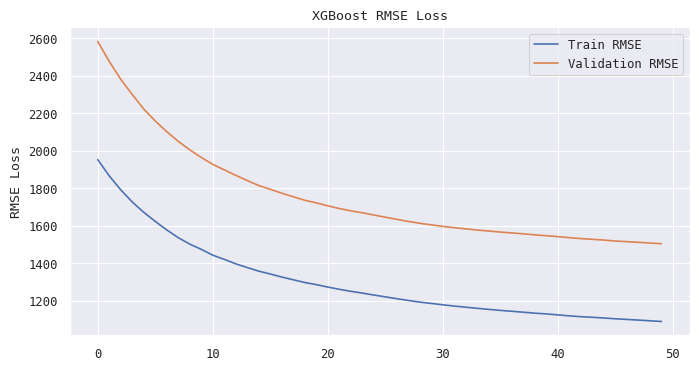

In [219]:
results = xgbmodel.evals_result()
train_mae, val_mae = results["validation_0"]["rmse"], results["validation_1"]["rmse"]
x_values = range(0, len(train_mae))
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(x_values, train_mae, label="Train RMSE")
ax.plot(x_values, val_mae, label="Validation RMSE")
ax.legend()
plt.ylabel("RMSE Loss")
plt.title("XGBoost RMSE Loss")
plt.show()

In [220]:
train_pred = xgbmodel.predict(X_train_flat1)
val_pred = xgbmodel.predict(X_val_flat1)
test_pred = xgbmodel.predict(X_test_flat1)

xg_y_train_pred = reformat_predictions_actual(train_pred, org_X_train)
xg_y_val_pred = reformat_predictions_actual(val_pred, org_X_val)
xg_y_test_pred = reformat_predictions_actual(test_pred, org_X_test)

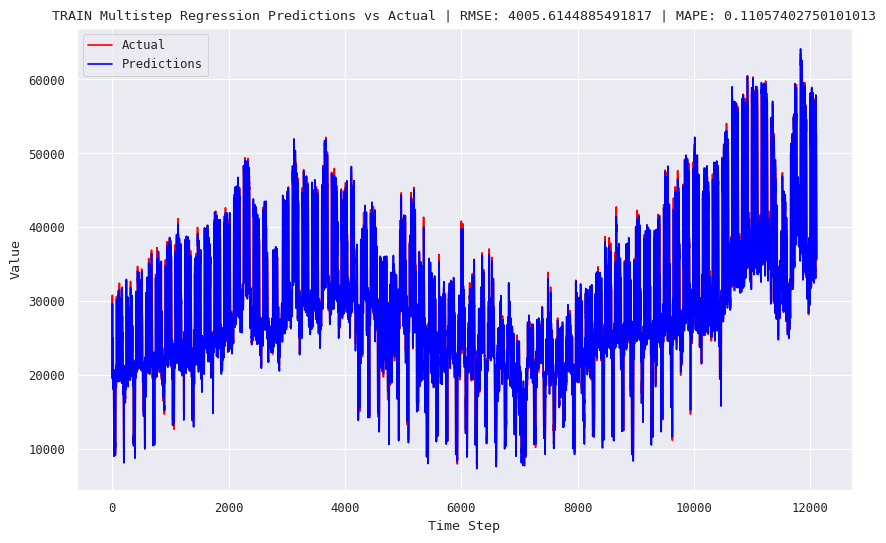

In [221]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

plt.figure(figsize=(10, 6))
plt.plot(org_y_train[:,0], label='Actual', color='red')
plt.plot(xg_y_train_pred[:,0], label='Predictions', color='blue')

plt.title(f'TRAIN Multistep Regression Predictions vs Actual | RMSE: {np.sqrt(mean_squared_error(org_y_train, xg_y_train_pred))} | MAPE: {mean_absolute_percentage_error(org_y_train+1, xg_y_train_pred+1)}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

Selected Features:
installed_capacity
dewpoint
rain
surface_pressure
cloudcover_total
cloudcover_low
cloudcover_mid
windspeed_10m
shortwave_radiation
direct_solar_radiation
lowest_price_per_mwh
euros_per_mwh
24h_forecasted_cloudcover_low
24h_forecasted_10_metre_u_wind_component
24h_forecasted_10_metre_v_wind_component
24h_forecasted_direct_solar_radiation
24h_forecasted_surface_solar_radiation_downwards
hour
target_production
capacity_per_eic


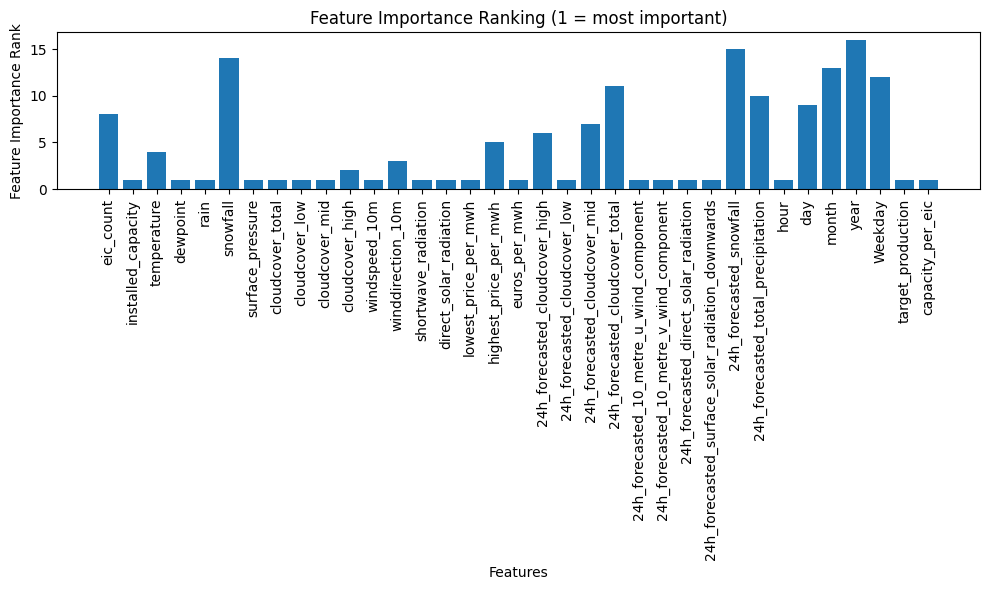

In [52]:
## supply RFE
supply_feat_sel_df = filtered_df.copy()
supply_feat_sel_df = supply_feat_sel_df.dropna()

train_y = demand_feat_sel_df['diff_supply']
train_X = demand_feat_sel_df.drop(["diff_demand","diff_supply"], axis=1)

rfe = RFE(RandomForestRegressor(n_estimators=100, random_state=42), n_features_to_select=20)
fit = rfe.fit(train_X, train_y)

print('Selected Features:')
names = train_X.columns.values
for i in range(len(fit.support_)):
    if fit.support_[i]:
        print(names[i])

plt.figure(figsize=(10, 6))
plt.bar(range(train_X.shape[1]), fit.ranking_)
plt.xticks(range(train_X.shape[1]), names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature Importance Rank')
plt.title('Feature Importance Ranking (1 = most important)')
plt.tight_layout()  
plt.show()


In [53]:
print('Dropped Features:')
dropped_features = train_X.columns.values[~fit.support_]
print(dropped_features)

Dropped Features:
['eic_count' 'temperature' 'snowfall' 'cloudcover_high'
 'winddirection_10m' 'highest_price_per_mwh'
 '24h_forecasted_cloudcover_high' '24h_forecasted_cloudcover_mid'
 '24h_forecasted_cloudcover_total' '24h_forecasted_snowfall'
 '24h_forecasted_total_precipitation' 'day' 'month' 'year' 'Weekday']


In [54]:
selected_features = train_X.columns[fit.support_]

filtered_df = final_df[list(selected_features) + ['diff_demand'] + ['demand']]

filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15236 entries, 2021-09-01 03:00:00 to 2023-05-29 00:00:00
Data columns (total 22 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   installed_capacity                                15236 non-null  float64
 1   dewpoint                                          15236 non-null  float64
 2   rain                                              15236 non-null  float64
 3   surface_pressure                                  15236 non-null  float64
 4   cloudcover_total                                  15236 non-null  float64
 5   cloudcover_low                                    15236 non-null  float64
 6   cloudcover_mid                                    15236 non-null  float64
 7   windspeed_10m                                     15236 non-null  float64
 8   shortwave_radiation                               15236 non-n

# CNN testing difference 

In [138]:

import tensorflow as tf
from keras.layers import Bidirectional, Dense, Conv1D,MaxPooling1D, Dropout, LSTM, ReLU, Flatten, TimeDistributed, RepeatVector, LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

def build_lstm_model(X, y):
    tf.random.set_seed(22)
    
    cnn_lstm_model = Sequential()
    cnn_lstm_model.add((Conv1D(filters=64, kernel_size=3, padding='valid', input_shape= (X.shape[1],X.shape[2]))))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2))
    cnn_lstm_model.add((Conv1D(filters=32, kernel_size=3, padding='valid')))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2))
    cnn_lstm_model.add((Conv1D(filters=16, kernel_size=3, padding='valid')))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2))
    cnn_lstm_model.add(Dropout(0.25))

    cnn_lstm_model.add(Flatten())

    cnn_lstm_model.add(RepeatVector(y.shape[1]))

    cnn_lstm_model.add(Bidirectional(LSTM(128, activation='swish', return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(Flatten())
    cnn_lstm_model.add(RepeatVector(y.shape[1]))
    cnn_lstm_model.add(Bidirectional(LSTM(128, activation='swish', return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(TimeDistributed(Dense(1)))
    cnn_lstm_model.compile(optimizer='adam', loss='mse')
    cnn_lstm_model.summary()
    return cnn_lstm_model

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)


In [139]:
# non feature selected dataset
df = final_df.copy()

n_past = 48
n_future = 24
target_column_name = 'diff_demand'
train_df, val_df, test_df = df[1:int(len(df)*0.8)], df[int(len(df)*0.8):int(len(df)*0.8)+int(len(df)*0.1)], df[int(len(df)*0.8)+int(len(df)*0.1):] 
feature_column_names = train_df.drop(columns=['target', 'supply', 'diff_supply', 'demand']).columns

dataframe_scaler = dataframe_scaler.fit(train_df)
inverse_scaler = inverse_scaler.fit(train_df[[target_column_name]])

scaled_train_df = pd.DataFrame(dataframe_scaler.transform(train_df), columns = train_df.columns)
scaled_val_df = pd.DataFrame(dataframe_scaler.transform(val_df), columns = val_df.columns)
scaled_test_df = pd.DataFrame(dataframe_scaler.transform(test_df), columns = test_df.columns)

scaled_X_train, scaled_y_train = split_series(scaled_train_df,n_past, n_future, target_column_name, feature_column_names)
scaled_X_val, scaled_y_val = split_series(scaled_val_df,n_past, n_future, target_column_name, feature_column_names)
scaled_X_test, scaled_y_test = split_series(scaled_test_df,n_past, n_future, target_column_name, feature_column_names)

X_train, y_train = split_series(train_df,n_past, n_future, target_column_name, feature_column_names)
X_val, y_val = split_series(val_df,n_past, n_future, target_column_name, feature_column_names)
X_test, y_test = split_series(test_df,n_past, n_future, target_column_name, feature_column_names)

org_X_train, org_y_train = split_series(train_df,n_past, n_future, 'demand', 'demand')
org_X_val, org_y_val = split_series(val_df,n_past, n_future, 'demand', 'demand')
org_X_test, org_y_test = split_series(test_df,n_past, n_future, 'demand', 'demand')

X shape: (12112, 48, 40), y shape: (12112, 24)
X shape: (1452, 48, 40), y shape: (1452, 24)
X shape: (1453, 48, 40), y shape: (1453, 24)
X shape: (12112, 48, 40), y shape: (12112, 24)
X shape: (1452, 48, 40), y shape: (1452, 24)
X shape: (1453, 48, 40), y shape: (1453, 24)
X shape: (12112, 48), y shape: (12112, 24)
X shape: (1452, 48), y shape: (1452, 24)
X shape: (1453, 48), y shape: (1453, 24)


In [140]:
cnn_lstm_model = build_lstm_model(scaled_X_train,scaled_y_train)

2024-03-17 01:00:55.986104: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-03-17 01:00:55.986135: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-17 01:00:55.986144: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-17 01:00:55.986850: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-17 01:00:55.987258: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 46, 64)            7744      
                                                                 
 max_pooling1d (MaxPooling1  (None, 23, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 21, 32)            6176      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 10, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 8, 16)             1552      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 4, 16)             0

In [141]:
with tf.device('cpu:0'): #my mac gpu sucks and trains really slow for some reason
    training_history = cnn_lstm_model.fit(scaled_X_train,scaled_y_train, epochs=10, batch_size=64, validation_data=(scaled_X_val, scaled_y_val), verbose=1, callbacks=[early_stopping])

Epoch 1/10


2024-03-17 01:01:00.107326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


190/190 [==============================] - 151s 774ms/step - loss: 0.0218 - val_loss: 0.0066
Epoch 2/10
190/190 [==============================] - 150s 790ms/step - loss: 0.0039 - val_loss: 0.0064
Epoch 3/10
190/190 [==============================] - 147s 771ms/step - loss: 0.0038 - val_loss: 0.0063
Epoch 4/10
190/190 [==============================] - 149s 783ms/step - loss: 0.0038 - val_loss: 0.0062
Epoch 5/10
190/190 [==============================] - 150s 790ms/step - loss: 0.0037 - val_loss: 0.0063
Epoch 6/10
190/190 [==============================] - 139s 733ms/step - loss: 0.0035 - val_loss: 0.0057
Epoch 7/10
190/190 [==============================] - 135s 709ms/step - loss: 0.0033 - val_loss: 0.0053
Epoch 8/10
190/190 [==============================] - 377s 2s/step - loss: 0.0030 - val_loss: 0.0050
Epoch 9/10
190/190 [==============================] - 1035s 5s/step - loss: 0.0028 - val_loss: 0.0047
Epoch 10/10
190/190 [==============================] - 73s 382ms/step - loss: 0.

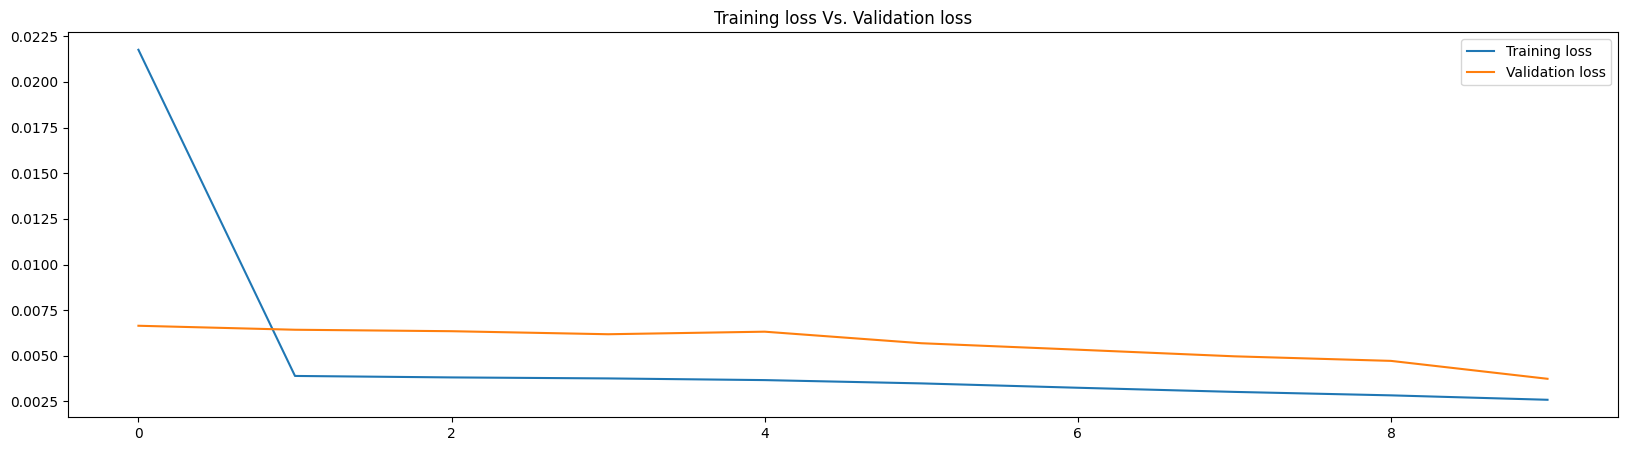

In [142]:
plt.figure(figsize=(20,5))
plt.plot(training_history.history['loss'], label='Training loss')
plt.plot(training_history.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss')
plt.legend()

In [143]:
nn_y_train_pred = reformat_predictions_actual(inverse_scaler.inverse_transform(cnn_lstm_model.predict(scaled_X_train).reshape(y_train.shape)), org_X_train)
nn_y_val_pred = reformat_predictions_actual(inverse_scaler.inverse_transform(cnn_lstm_model.predict(scaled_X_val).reshape(y_val.shape)), org_X_val)
nn_y_test_pred = reformat_predictions_actual(inverse_scaler.inverse_transform(cnn_lstm_model.predict(scaled_X_test).reshape(y_test.shape)), org_X_test)

46/46 [==============================] - 10s 227ms/step


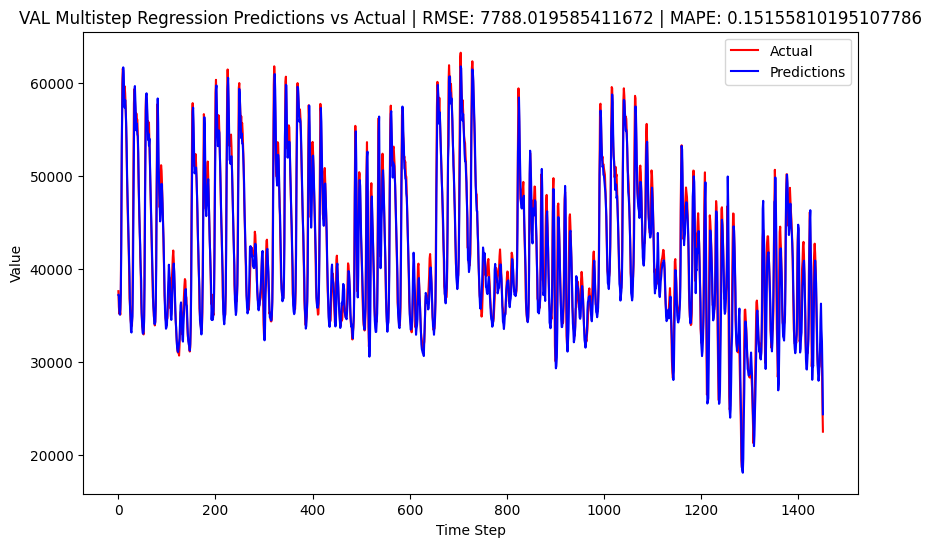

In [144]:
plt.figure(figsize=(10, 6))
plt.plot(org_y_val[:,0], label='Actual', color='red')
plt.plot(nn_y_val_pred[:,0], label='Predictions', color='blue')

plt.title(f'VAL Multistep Regression Predictions vs Actual | RMSE: {np.sqrt(mean_squared_error(org_y_val, nn_y_val_pred))} | MAPE: {mean_absolute_percentage_error(org_y_val+1, nn_y_val_pred+1)}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

# CNN with feature selection 

In [145]:
filtered_df

installed_capacity   dewpoint  rain  surface_pressure  \
datetime                                                                     
2021-09-01 04:00:00           70659.260  10.410714   0.0       1008.670536   
2021-09-01 05:00:00           70659.260  10.212500   0.0       1008.514286   
2021-09-01 06:00:00           70659.260  10.075000   0.0       1008.213393   
2021-09-01 07:00:00           70659.260  10.168750   0.0       1008.350000   
2021-09-01 08:00:00           70659.260  10.025893   0.0       1008.260714   
...                                 ...        ...   ...               ...   
2023-05-28 20:00:00          148058.705   6.007143   0.0       1011.966071   
2023-05-28 21:00:00          148058.705   6.326786   0.0       1011.901786   
2023-05-28 22:00:00          148058.705   6.600893   0.0       1011.999107   
2023-05-28 23:00:00          148058.705   6.831250   0.0       1011.895536   
2023-05-29 00:00:00          148218.705   7.034821   0.0       1011.789286   

                     cloudcover_total  cloudcover_low  cloudcover_mid  \
datetime                                                                
2021-09-01 04:00:00         29.973214       26.767857        3.178571   
2021-09-01 05:00:00         26.285714       22.883929        2.946429   
2021-09-01 06:00:00         29.026786       23.339286        4.107143   
2021-09-01 07:00:00         27.767857       19.044643        6.910714   
2021-09-01 08:00:00         32.187500       22.446429        8.035714   
...                               ...             ...             ...   
2023-05-28 20:00:00         33.625000       16.875000       32.080357   
2023-05-28 21:00:00         21.491071       12.419643       18.196429   
2023-05-28 22:00:00         23.205357       13.401786       19.758929   
2023-05-28 23:00:00         21.866071       12.294643       19.419643   
2023-05-29 00:00:00         35.508929       13.562500       38.687500   

                     shortwave_radiation  direct_solar_radiation  \
datetime                                                           
2021-09-01 04:00:00             0.000000                0.000000   
2021-09-01 05:00:00             0.000000                0.000000   
2021-09-01 06:00:00             9.982143                3.196429   
2021-09-01 07:00:00            80.107143               38.607143   
2021-09-01 08:00:00           186.401786              109.491071   
...                                  ...                     ...   
2023-05-28 20:00:00            86.982143               42.875000   
2023-05-28 21:00:00            19.964286                7.464286   
2023-05-28 22:00:00             0.107143                0.000000   
2023-05-28 23:00:00             0.000000                0.000000   
2023-05-29 00:00:00             0.151786                0.000000   

                     diffuse_radiation  ...  \
datetime                                ...   
2021-09-01 04:00:00           0.000000  ...   
2021-09-01 05:00:00           0.000000  ...   
2021-09-01 06:00:00           6.785714  ...   
2021-09-01 07:00:00          41.500000  ...   
2021-09-01 08:00:00          76.910714  ...   
...                                ...  ...   
2023-05-28 20:00:00          44.107143  ...   
2023-05-28 21:00:00          12.500000  ...   
2023-05-28 22:00:00           0.107143  ...   
2023-05-28 23:00:00           0.000000  ...   
2023-05-29 00:00:00           0.151786  ...   

                     24h_forecasted_10_metre_u_wind_component  \
datetime                                                        
2021-09-01 04:00:00                                  2.222443   
2021-09-01 05:00:00                                  2.423018   
2021-09-01 06:00:00                                  2.579115   
2021-09-01 07:00:00                                  2.711851   
2021-09-01 08:00:00                                  2.943281   
...                                                       ...   
2023-05-28 20:00:00                    

In [147]:
df = filtered_df.copy()
n_past = 48
n_future = 24
target_column_name = 'diff_demand'
train_df, val_df, test_df = df[1:int(len(df)*0.8)], df[int(len(df)*0.8):int(len(df)*0.8)+int(len(df)*0.1)], df[int(len(df)*0.8)+int(len(df)*0.1):] 
feature_column_names = train_df.columns

# feature_column_names = ['target', 'eic_count','forecasted_temperature','forecasted_direct_solar_radiation','forecasted_surface_solar_radiation_downwards','hour','month','day']

dataframe_scaler = MinMaxScaler()
dataframe_scaler = dataframe_scaler.fit(train_df)
inverse_scaler = MinMaxScaler()
inverse_scaler = inverse_scaler.fit(train_df[[target_column_name]])

scaled_train_df = pd.DataFrame(dataframe_scaler.transform(train_df), columns = train_df.columns)
scaled_val_df = pd.DataFrame(dataframe_scaler.transform(val_df), columns = val_df.columns)
scaled_test_df = pd.DataFrame(dataframe_scaler.transform(test_df), columns = test_df.columns)

scaled_X_train, scaled_y_train = split_series(scaled_train_df,n_past, n_future, target_column_name, feature_column_names)
scaled_X_val, scaled_y_val = split_series(scaled_val_df,n_past, n_future, target_column_name, feature_column_names)
scaled_X_test, scaled_y_test = split_series(scaled_test_df,n_past, n_future, target_column_name, feature_column_names)

X_train, y_train = split_series(train_df,n_past, n_future, target_column_name, feature_column_names)
X_val, y_val = split_series(val_df,n_past, n_future, target_column_name, feature_column_names)
X_test, y_test = split_series(test_df,n_past, n_future, target_column_name, feature_column_names)

org_X_train, org_y_train = split_series(train_df,n_past, n_future, 'demand', 'demand')
org_X_val, org_y_val = split_series(val_df,n_past, n_future, 'demand', 'demand')
org_X_test, org_y_test = split_series(test_df,n_past, n_future, 'demand', 'demand')


X shape: (12112, 48, 22), y shape: (12112, 24)
X shape: (1452, 48, 22), y shape: (1452, 24)
X shape: (1453, 48, 22), y shape: (1453, 24)
X shape: (12112, 48, 22), y shape: (12112, 24)
X shape: (1452, 48, 22), y shape: (1452, 24)
X shape: (1453, 48, 22), y shape: (1453, 24)
X shape: (12112, 48), y shape: (12112, 24)
X shape: (1452, 48), y shape: (1452, 24)
X shape: (1453, 48), y shape: (1453, 24)


In [148]:
cnn_lstm_model = build_lstm_model(scaled_X_train,scaled_y_train)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 46, 64)            4288      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 23, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 21, 32)            6176      
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 10, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 8, 16)             1552      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 4, 16)            

In [149]:
with tf.device('cpu:0'): #my mac gpu sucks and trains really slow for some reason
    training_history = cnn_lstm_model.fit(scaled_X_train,scaled_y_train, epochs=10, batch_size=64, validation_data=(scaled_X_val, scaled_y_val), verbose=1, callbacks=[early_stopping])

Epoch 1/10
190/190 [==============================] - 75s 383ms/step - loss: 0.0056 - val_loss: 0.0064
Epoch 2/10
190/190 [==============================] - 85s 446ms/step - loss: 0.0036 - val_loss: 0.0058
Epoch 3/10
190/190 [==============================] - 173s 912ms/step - loss: 0.0030 - val_loss: 0.0044
Epoch 4/10
190/190 [==============================] - 324s 2s/step - loss: 0.0024 - val_loss: 0.0034
Epoch 5/10
190/190 [==============================] - 1957s 10s/step - loss: 0.0019 - val_loss: 0.0027
Epoch 6/10
190/190 [==============================] - 72s 376ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 7/10
190/190 [==============================] - 1449s 8s/step - loss: 0.0015 - val_loss: 0.0022
Epoch 8/10
190/190 [==============================] - 1096s 6s/step - loss: 0.0015 - val_loss: 0.0021
Epoch 9/10
190/190 [==============================] - 991s 5s/step - loss: 0.0014 - val_loss: 0.0021
Epoch 10/10
190/190 [==============================] - 1203s 6s/step - loss: 0

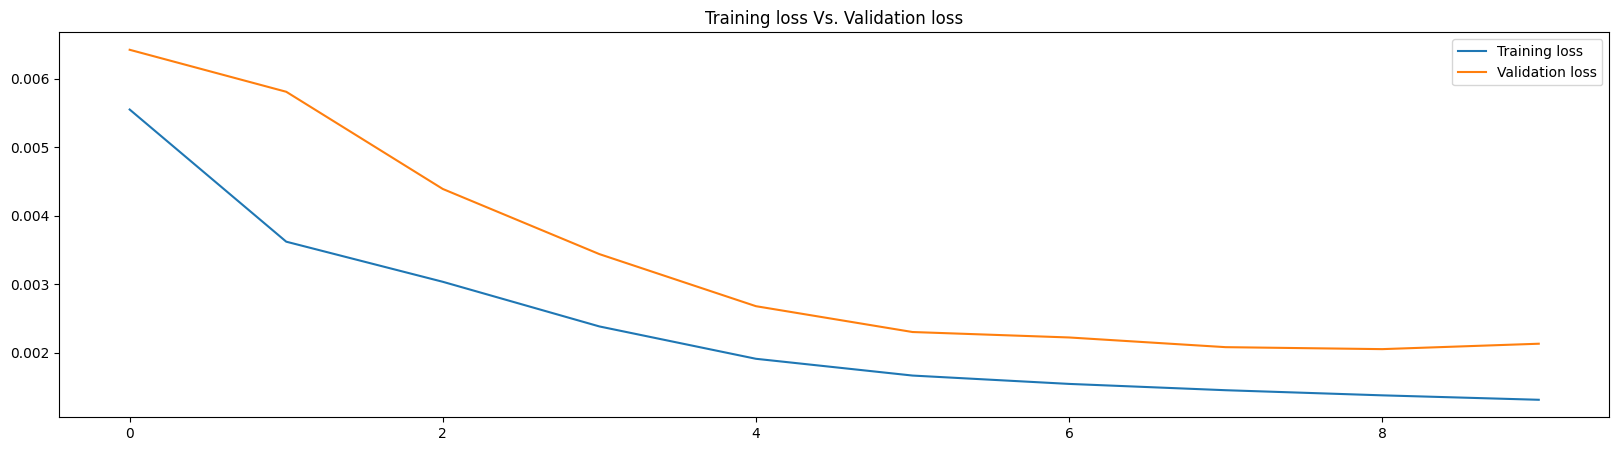

In [150]:
plt.figure(figsize=(20,5))
plt.plot(training_history.history['loss'], label='Training loss')
plt.plot(training_history.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss')
plt.legend()

In [151]:
nn_y_train_pred = reformat_predictions_actual(inverse_scaler.inverse_transform(cnn_lstm_model.predict(scaled_X_train).reshape(y_train.shape)), org_X_train)
nn_y_val_pred = reformat_predictions_actual(inverse_scaler.inverse_transform(cnn_lstm_model.predict(scaled_X_val).reshape(y_val.shape)), org_X_val)
nn_y_test_pred = reformat_predictions_actual(inverse_scaler.inverse_transform(cnn_lstm_model.predict(scaled_X_test).reshape(y_test.shape)), org_X_test)

46/46 [==============================] - 9s 194ms/step


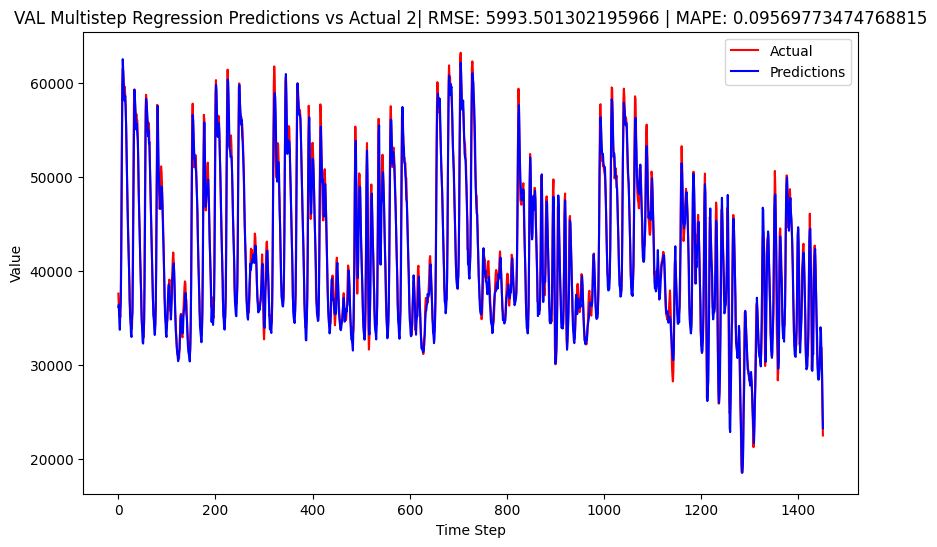

In [152]:
plt.figure(figsize=(10, 6))
plt.plot(org_y_val[:,0], label='Actual', color='red')
plt.plot(nn_y_val_pred[:,0], label='Predictions', color='blue')

plt.title(f'VAL Multistep Regression Predictions vs Actual 2| RMSE: {np.sqrt(mean_squared_error(org_y_val, nn_y_val_pred))} | MAPE: {mean_absolute_percentage_error(org_y_val+1, xg_y_val_pred+1)}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show() 